In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from utils.utils import remove_blacklisted, remove_redundant_columns, filter_device_groups
import joblib

hc = 'HC212B'
prefix = f'tr_20230127213409_{hc}_'
#y_name = f'LMAM_{hc}_PLKL90---_TPG'
y_name = f'LMAM_{hc}_PL-------_TPS'
#groups = ["1", "2", "3"]
groups = ["1", "4", "5"]

df = pd.read_csv(f'001_extract.csv')

df = remove_blacklisted(df, file='feature_lists/blacklist15.txt')
df = remove_redundant_columns(df)
df = filter_device_groups(df, file='feature_lists/15groups.json', groups=groups, y_name=y_name)

print(df.columns)
columns_list = df.columns.to_list()


Index(['LMAM_OBM1C2_WPPT01---_TPI', 'LMAM_MP211-_RDXRFI2--_PV',
       'LMAM_MP211-_---------_EPX', 'LMAM_MP211-_RDXRFI1--_PV',
       'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_MP211-_WPXRFI2--_PV',
       'LMAM_TM141-_RDFQ01---_TFI', 'LMAM_TM211-_---------_EPX',
       'LMAM_TM212-_---------_EPX', 'LMAM_K211--_WPXRFI1--_PV',
       'LMAM_TM213-_---------_EPX', 'LMAM_RZM212_NDLT01---_TLI',
       'LMAM_RZM212_WPFT01---_TFI', 'LMAM_RZM212_NDXSLI16-_PV',
       'LMAM_MK212-_WPXRFI1--_PV', 'LMAM_MK212-_---------_EPX',
       'LMAM_HC212-_NDXSDI8--_PV', 'LMAM_HC212-_NDXSDI16-_PV',
       'LMAM_HC212A_NDPT01---_TPI', 'LMAM_HC212A_WPFT01---_TFI',
       'LMAM_HC212A_NDFT01---_TFI', 'LMAM_HC212A_NDDT01---_TDI',
       'LMAM_PM212A_--FAL2---_TNI_ERPM', 'LMAM_PM212A_--FAL1---_TNI_ERPM',
       'LMAM_PM212A_--FAL1---_EI3', 'LMAM_PM212A_--FAL2---_EI3',
       'LMAM_PM212A_---------_EPX', 'LMAM_PM212B_---------_EPX',
       'LMAM_PM212B_---------_TNI', 'LMAM_HC212B_PL-------_TPS'],
      dtype='object')


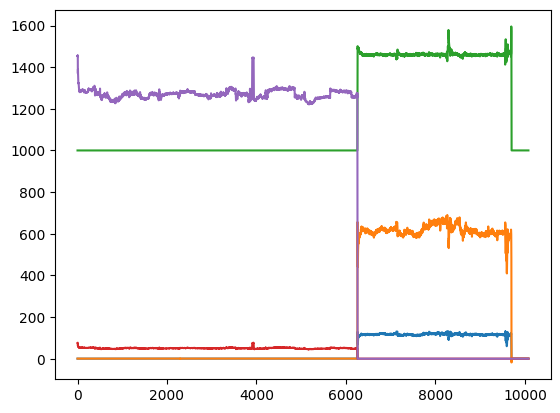

In [73]:
keep_indices = [0,5,9,11,12,13,16,17,14,15]
merge_indices = [18,20,21,27,28]
outlier_indices = [1,2,3,4,7,8]



def plot_by_indices(df, indices):
    for idx in indices:
        plt.plot(range(len(df)), df[columns_list[idx]], label=columns_list[idx])

def plot_all(df):
    for idx, col in enumerate(df.columns):
        plt.plot(range(len(df)), df[col], label=columns_list[idx])
        plt.legend()


plot_by_indices(df, merge_indices)

LMAM_MP211-_RDXRFI2--_PV      43.242192
LMAM_MP211-_---------_EPX     52.023161
LMAM_MP211-_RDXRFI1--_PV      41.588560
LMAM_MP211-_WLEQ01---_TDI    162.509369
LMAM_TM211-_---------_EPX      1.158483
LMAM_TM212-_---------_EPX      1.335576
dtype: float64
LMAM_MP211-_RDXRFI2--_PV      204.612757
LMAM_MP211-_---------_EPX     253.746283
LMAM_MP211-_RDXRFI1--_PV      196.559700
LMAM_MP211-_WLEQ01---_TDI    1783.077229
LMAM_TM211-_---------_EPX       5.653051
LMAM_TM212-_---------_EPX       6.115875
dtype: float64


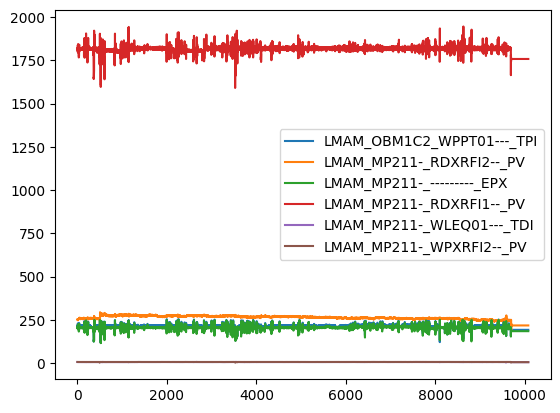

In [74]:
# SMOOOOOOOOOOOOOOOOOOOTH

from processing.smoothing import wma_smoothing

smooooooth_df = wma_smoothing(df[np.array(columns_list)[outlier_indices]])

plot_all(smooooooth_df)

In [75]:
# MEEEEEEEEERGE

df_unified = pd.read_csv('unifiedData.csv')
print(np.array(columns_list)[merge_indices])
df_unified.head(10)

['LMAM_HC212A_NDPT01---_TPI' 'LMAM_HC212A_NDFT01---_TFI'
 'LMAM_HC212A_NDDT01---_TDI' 'LMAM_PM212B_---------_EPX'
 'LMAM_PM212B_---------_TNI']


,LMAM_PM212U_---------_TNI,LMAM_HC212U_NDDT01---_TDI,LMAM_PM212U_---------_EPX,LMAM_HC212U_NDFT01---_TFI
0,1454.066588,1377.956414,74.992500,4.260885
1,1454.487743,1381.955865,75.069062,11.421482
2,1456.131163,1385.105223,76.202032,7.903802
3,1452.109602,1378.809072,75.828593,0.000000
4,1456.138011,1369.217996,76.207655,0.000000
5,1456.627867,1365.851855,76.772187,0.000000
6,1454.853962,1359.994737,76.184376,0.000000
7,1416.242699,1355.842770,69.161403,0.000000
8,1369.862979,1356.046315,61.712344,0.000000
9,1383.513907,1353.495527,62.943437,0.000000


In [76]:
df_after_merge = df_unified.copy().drop(columns='LMAM_HC212U_NDFT01---_TFI')
df_after_merge

,LMAM_PM212U_---------_TNI,LMAM_HC212U_NDDT01---_TDI,LMAM_PM212U_---------_EPX
0,1454.066588,1377.956414,74.992500
1,1454.487743,1381.955865,75.069062
2,1456.131163,1385.105223,76.202032
3,1452.109602,1378.809072,75.828593
4,1456.138011,1369.217996,76.207655
...,...,...,...
10075,0.000000,1000.000000,0.053336
10076,0.000000,1000.000000,0.030156
10077,0.000000,1000.000000,0.035764
10078,0.000000,1000.000000,0.032632


In [77]:
smooooooth_df

,LMAM_MP211-_RDXRFI2--_PV,LMAM_MP211-_---------_EPX,LMAM_MP211-_RDXRFI1--_PV,LMAM_MP211-_WLEQ01---_TDI,LMAM_TM211-_---------_EPX,LMAM_TM212-_---------_EPX
0,211.789454,252.002747,202.191798,1805.605745,5.952253,6.484909
1,215.695052,251.902037,206.537499,1812.662786,5.972225,6.465025
2,213.032032,250.896467,203.101954,1811.585276,5.995128,6.443522
3,216.496223,250.103762,206.486718,1815.718092,5.926397,6.397191
4,213.356900,251.802853,203.816796,1811.305091,5.850534,6.313125
...,...,...,...,...,...,...
10075,192.077906,217.494771,184.365146,1757.371644,5.235768,5.346740
10076,192.077906,217.494771,184.365146,1757.371644,5.235768,5.346740
10077,192.077906,217.494771,184.365146,1757.371644,5.235768,5.346740
10078,192.077906,217.494771,184.365146,1757.371644,5.235768,5.346740


In [86]:
pd.concat([df[np.array(columns_list)[keep_indices]], df_after_merge], axis=1, join="inner")

,LMAM_OBM1C2_WPPT01---_TPI,LMAM_MP211-_WPXRFI2--_PV,LMAM_K211--_WPXRFI1--_PV,LMAM_RZM212_NDLT01---_TLI,LMAM_RZM212_WPFT01---_TFI,LMAM_RZM212_NDXSLI16-_PV,LMAM_HC212-_NDXSDI8--_PV,LMAM_HC212-_NDXSDI16-_PV,LMAM_MK212-_WPXRFI1--_PV,LMAM_MK212-_---------_EPX,LMAM_PM212U_---------_TNI,LMAM_HC212U_NDDT01---_TDI,LMAM_PM212U_---------_EPX
0,296.299988,67.193186,251.669530,29.434478,103.286562,30.820223,1377.592837,1378.356993,17.037188,401.007111,1454.066588,1377.956414,74.992500
1,296.277488,67.102969,250.895621,23.345259,104.809533,24.368406,1380.124972,1380.816388,17.001719,401.007111,1454.487743,1381.955865,75.069062
2,290.927495,66.416562,249.246561,18.354531,110.864168,19.109157,1383.388190,1384.539640,16.857500,401.007111,1456.131163,1385.105223,76.202032
3,293.677632,66.630235,249.787499,17.558698,116.524167,17.392554,1383.175975,1379.389976,16.845833,401.007111,1452.109602,1378.809072,75.828593
4,293.500000,66.544686,249.527810,17.521133,120.220001,17.709564,1374.911005,1369.377657,16.850312,401.007111,1456.138011,1369.217996,76.207655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,223.752006,0.000000,0.000000,102.396873,0.047359,99.999123,1000.030640,1000.013550,0.000000,0.000000,0.000000,1000.000000,0.053336
10076,221.988553,0.000000,0.000000,102.396873,0.000019,99.999123,1000.030640,1000.013550,0.000000,0.000000,0.000000,1000.000000,0.030156
10077,220.368673,0.000000,0.000000,102.396873,0.028740,99.999123,1000.030640,1000.013550,0.000000,0.000000,0.000000,1000.000000,0.035764
10078,220.850006,0.000000,0.000000,102.396873,0.000000,99.999123,1000.030640,1000.013550,0.000000,0.000000,0.000000,1000.000000,0.032632


In [87]:
# KEEP + SMOOTH + MERGE


final_solution = pd.concat([
    df[np.array(columns_list)[keep_indices]], 
    df_after_merge,
    smooooooth_df,
    ],
    axis=1, 
    join="inner"
    )

final_solution.head(5)

,LMAM_OBM1C2_WPPT01---_TPI,LMAM_MP211-_WPXRFI2--_PV,LMAM_K211--_WPXRFI1--_PV,LMAM_RZM212_NDLT01---_TLI,LMAM_RZM212_WPFT01---_TFI,LMAM_RZM212_NDXSLI16-_PV,LMAM_HC212-_NDXSDI8--_PV,LMAM_HC212-_NDXSDI16-_PV,LMAM_MK212-_WPXRFI1--_PV,LMAM_MK212-_---------_EPX,LMAM_PM212U_---------_TNI,LMAM_HC212U_NDDT01---_TDI,LMAM_PM212U_---------_EPX,LMAM_MP211-_RDXRFI2--_PV,LMAM_MP211-_---------_EPX,LMAM_MP211-_RDXRFI1--_PV,LMAM_MP211-_WLEQ01---_TDI,LMAM_TM211-_---------_EPX,LMAM_TM212-_---------_EPX
0,296.299988,67.193186,251.669530,29.434478,103.286562,30.820223,1377.592837,1378.356993,17.037188,401.007111,1454.066588,1377.956414,74.992500,211.789454,252.002747,202.191798,1805.605745,5.952253,6.484909
1,296.277488,67.102969,250.895621,23.345259,104.809533,24.368406,1380.124972,1380.816388,17.001719,401.007111,1454.487743,1381.955865,75.069062,215.695052,251.902037,206.537499,1812.662786,5.972225,6.465025
2,290.927495,66.416562,249.246561,18.354531,110.864168,19.109157,1383.388190,1384.539640,16.857500,401.007111,1456.131163,1385.105223,76.202032,213.032032,250.896467,203.101954,1811.585276,5.995128,6.443522
3,293.677632,66.630235,249.787499,17.558698,116.524167,17.392554,1383.175975,1379.389976,16.845833,401.007111,1452.109602,1378.809072,75.828593,216.496223,250.103762,206.486718,1815.718092,5.926397,6.397191
4,293.500000,66.544686,249.527810,17.521133,120.220001,17.709564,1374.911005,1369.377657,16.850312,401.007111,1456.138011,1369.217996,76.207655,213.356900,251.802853,203.816796,1811.305091,5.850534,6.313125


In [94]:
final_solution.to_csv('finaaaaaaal15.csv', index=False)


import json 

with open('whitelist15_final.json', 'w') as f:
    json.dump(final_solution.columns.tolist(), f, indent=1)

In [96]:
ret = pd.concat([pd.read_csv('001_extract.csv'), df_after_merge], axis=1, join="inner")
ret.info()

ret.to_csv('maybe.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Columns: 156 entries, Czas to LMAM_PM212U_---------_EPX
dtypes: float64(155), object(1)
memory usage: 12.0+ MB


In [ ]:

X = df.drop(columns=y_name)
y = df[y_name]

test_size = 1000
split_index = 6000
X_train, X_test = pd.concat([X.iloc[0:split_index + 1], X.iloc[split_index + test_size:]]), X.iloc[split_index:split_index + test_size + 1]
y_train, y_test = pd.concat([y.iloc[0:split_index + 1], y.iloc[split_index + test_size:]]), y.iloc[split_index:split_index + test_size + 1]

model = XGBRegressor(
    # n_estimators=100, 
    # max_depth=15, 
    # eta=0.1, 
    # subsample=0.7, 
    # colsample_bytree=0.8
    )

cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=44)

scores = cross_val_score(model, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=cv, 
                         n_jobs=4
                    )


model.fit(X_train, y_train)
test_pred = model.predict(X_test)

joblib.dump(model, f'xgb15{hc}.joblib')

# force scores to be positive
scores = np.absolute(scores)
print('-'*20)
print('Scores')
print(f'Mean MSE: {scores.mean():.2f} +- {scores.std():.2f}')
print('-'*20)
print('Stats for Y')
print(f'Min {y.min():.2f}')
print(f'Max {y.max():.2f}')
print(f'Mean {y.mean():.2f}')

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


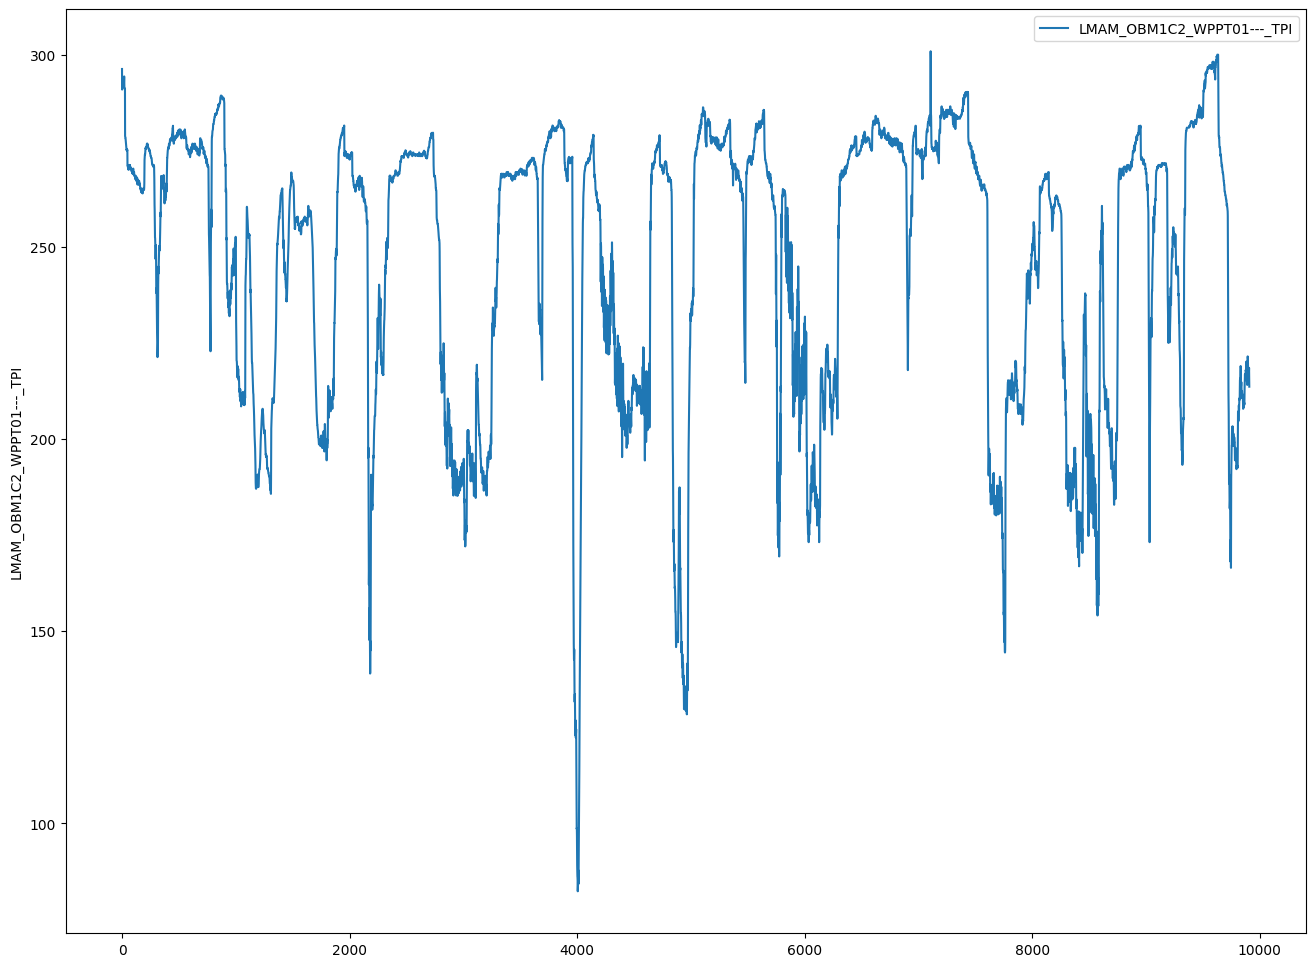

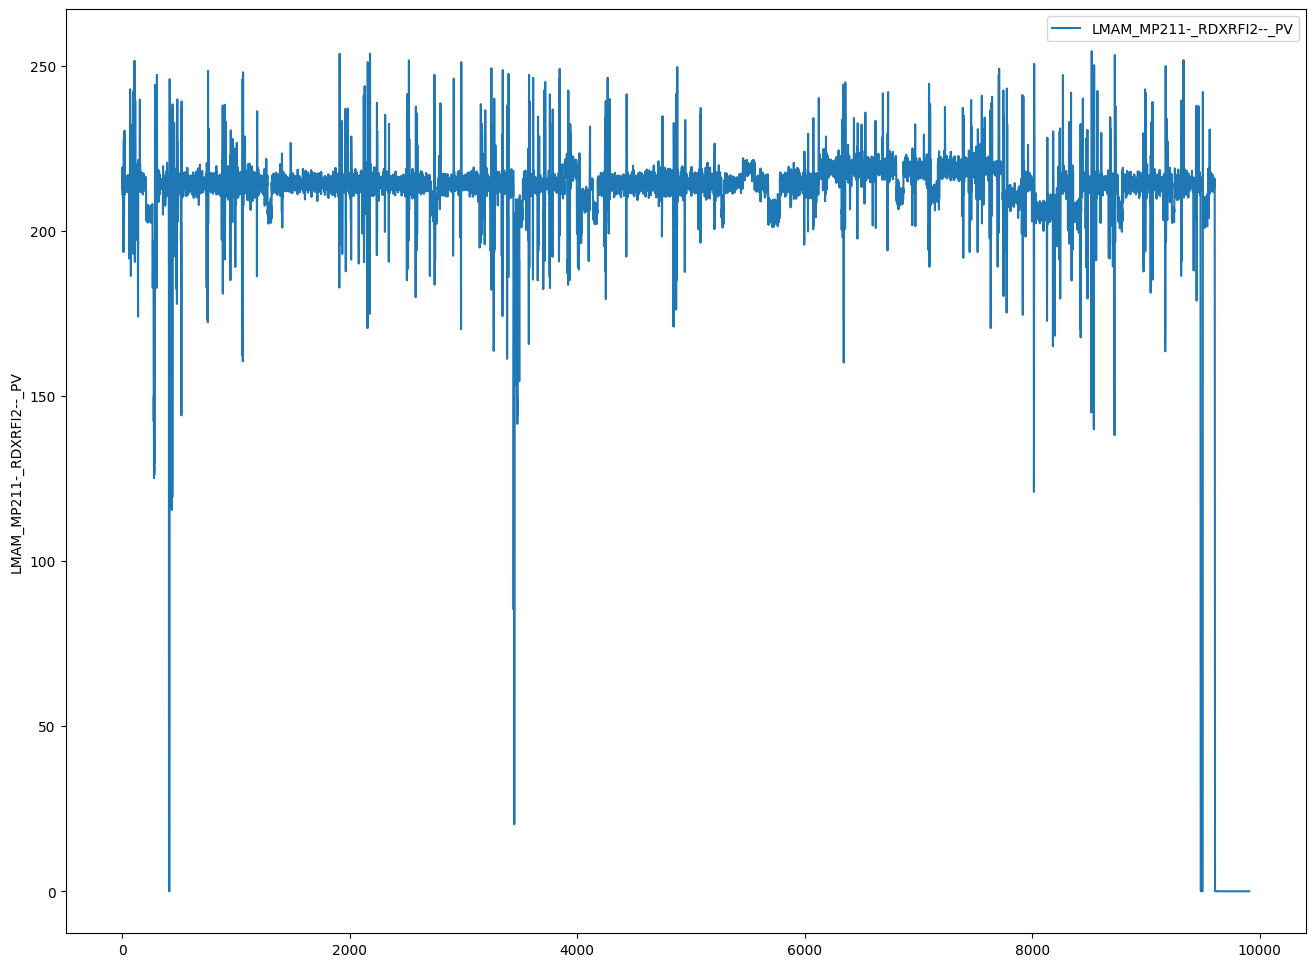

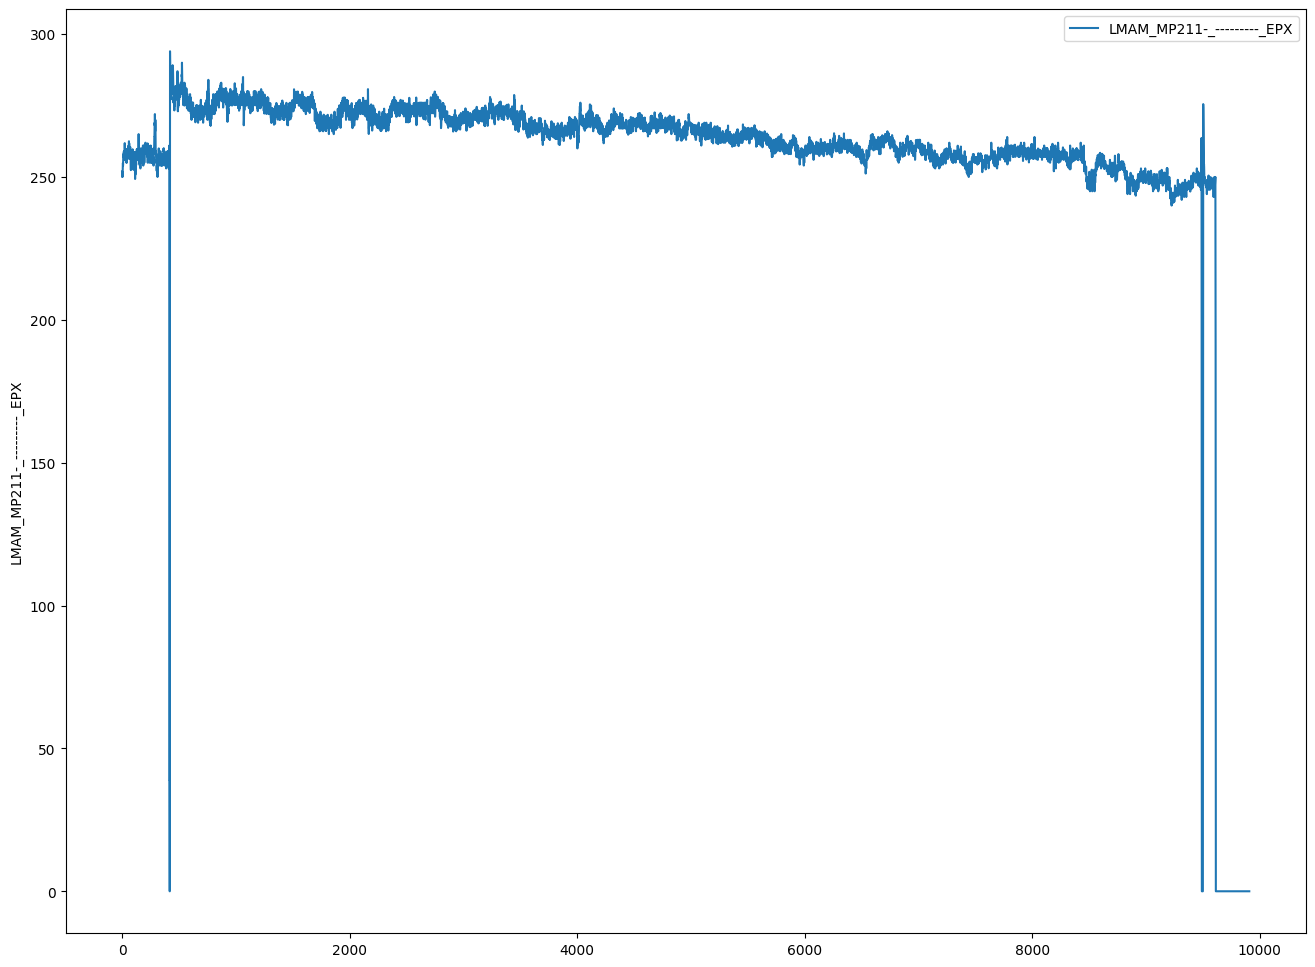

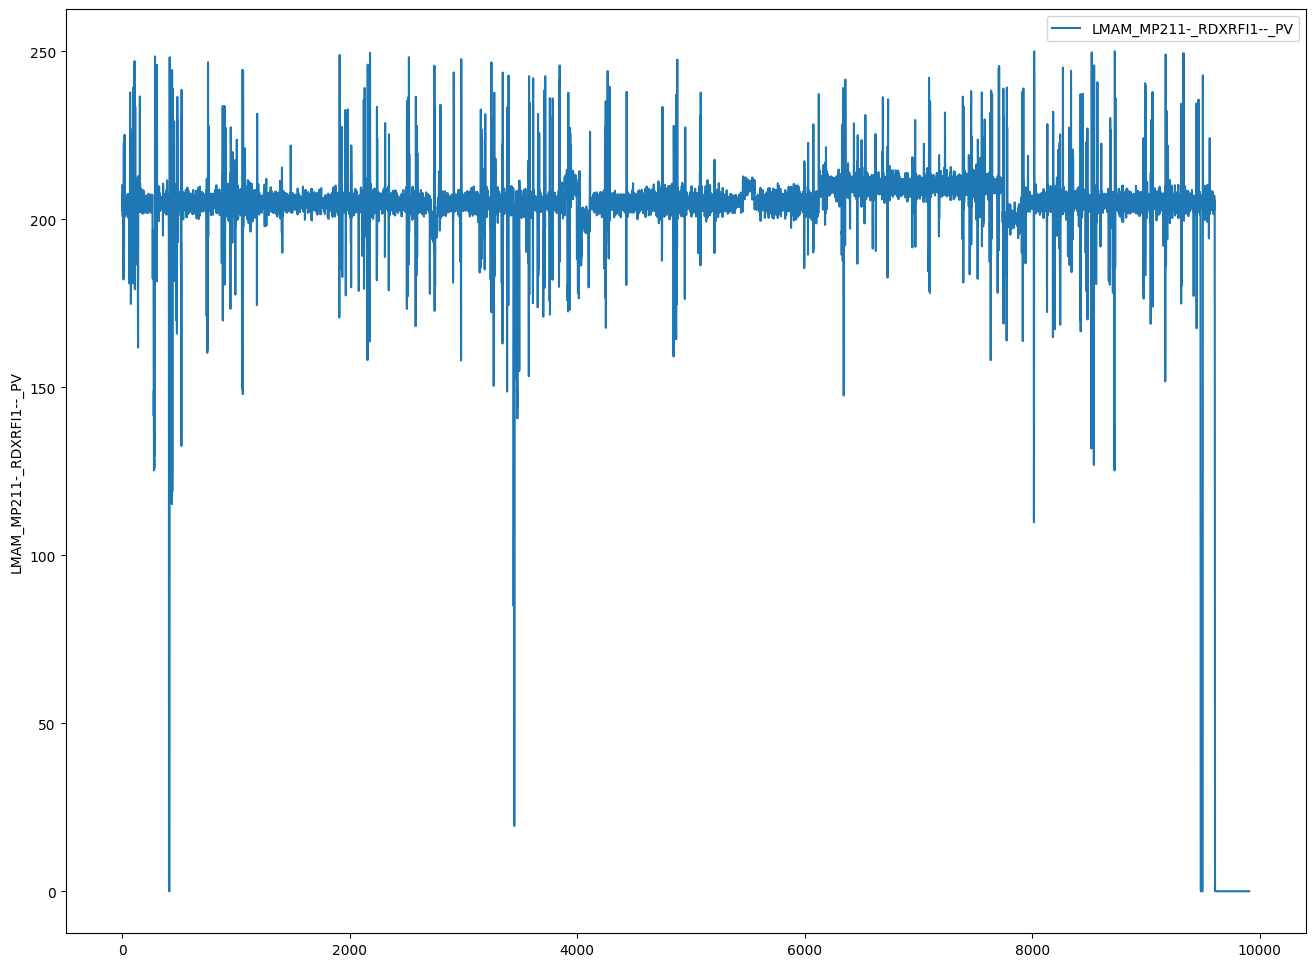

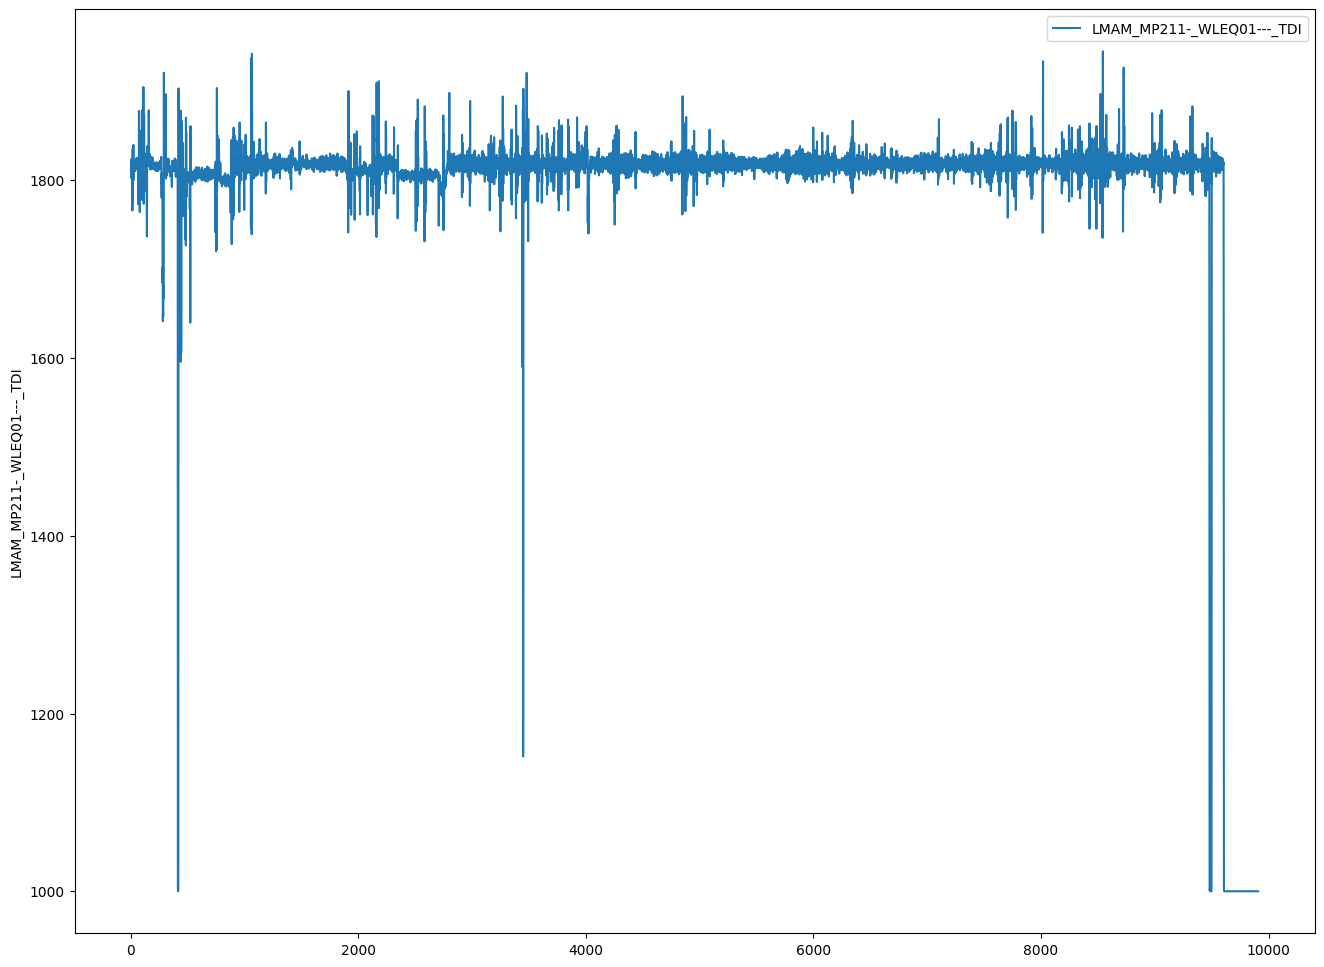

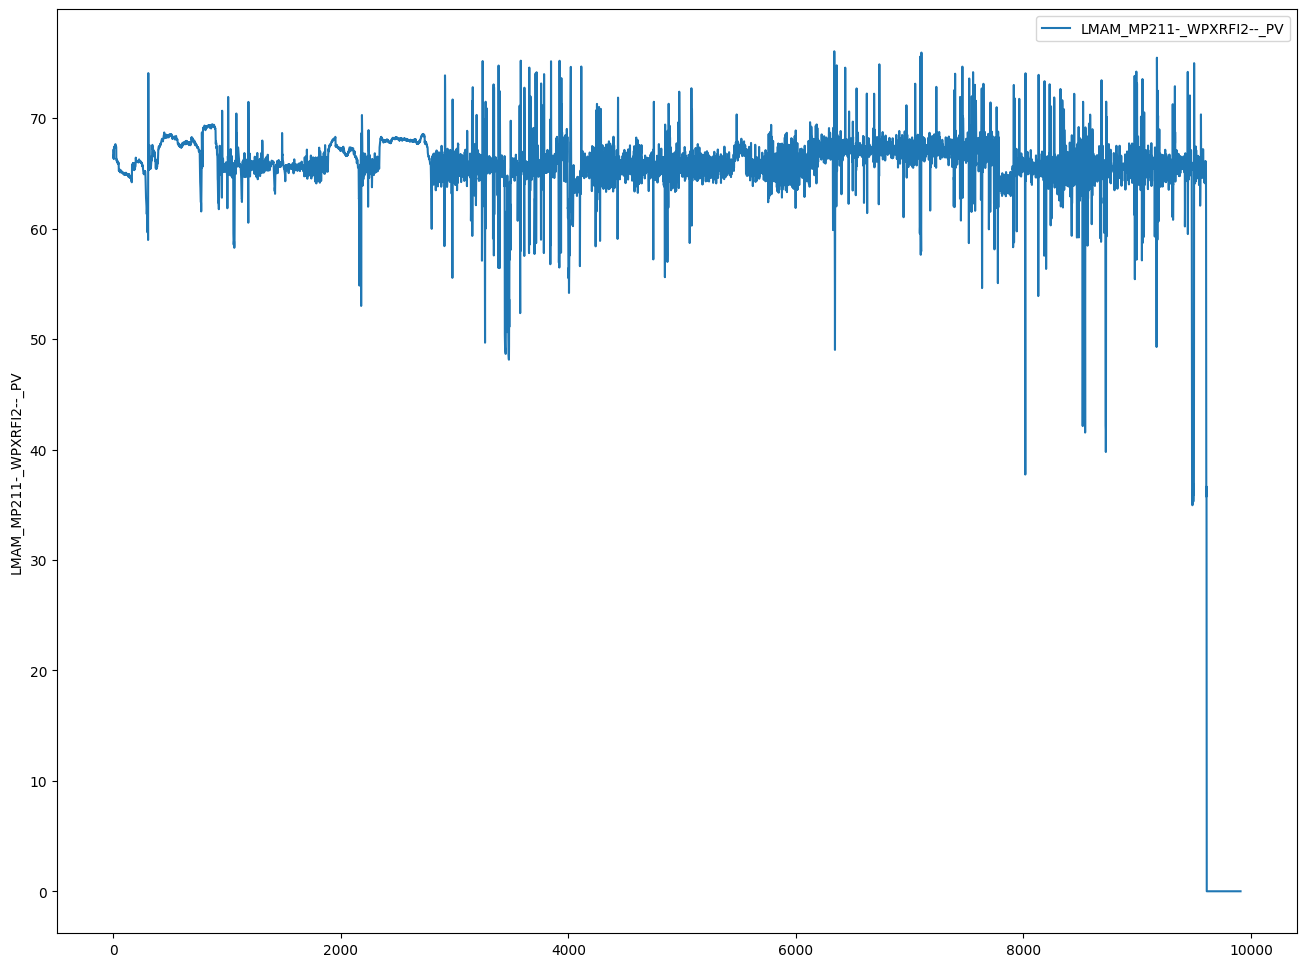

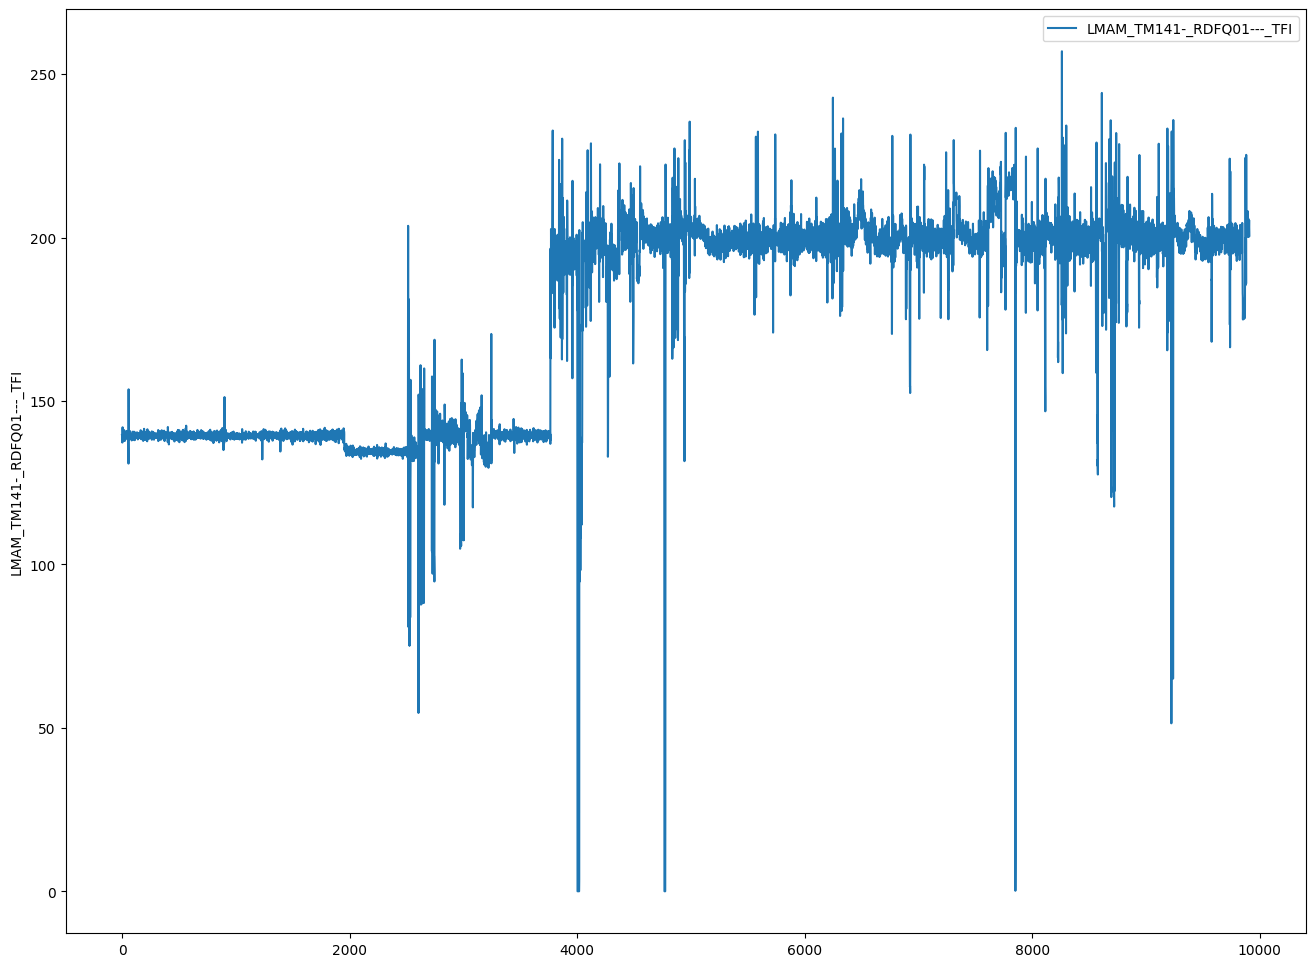

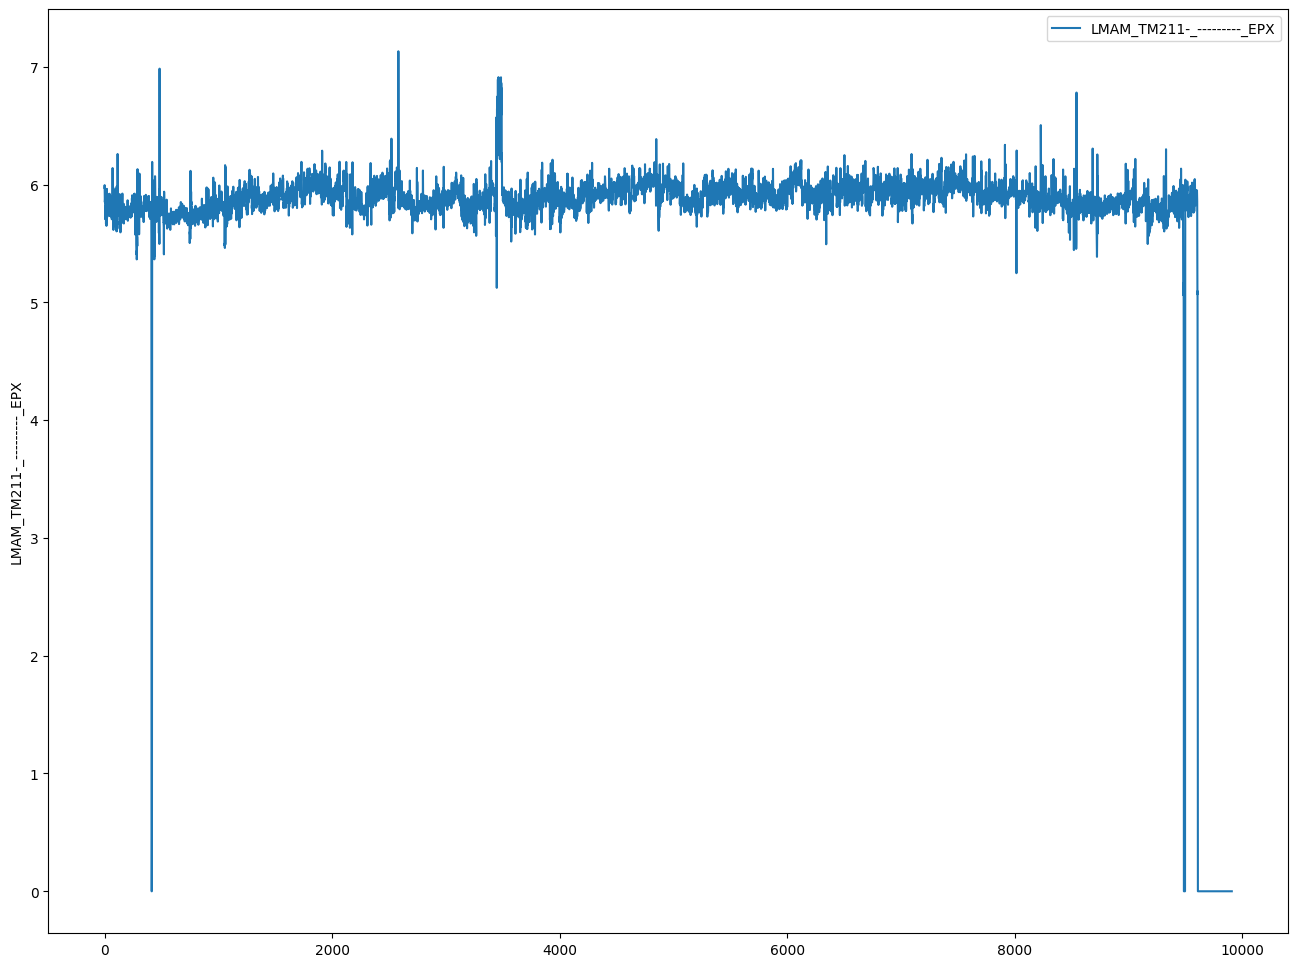

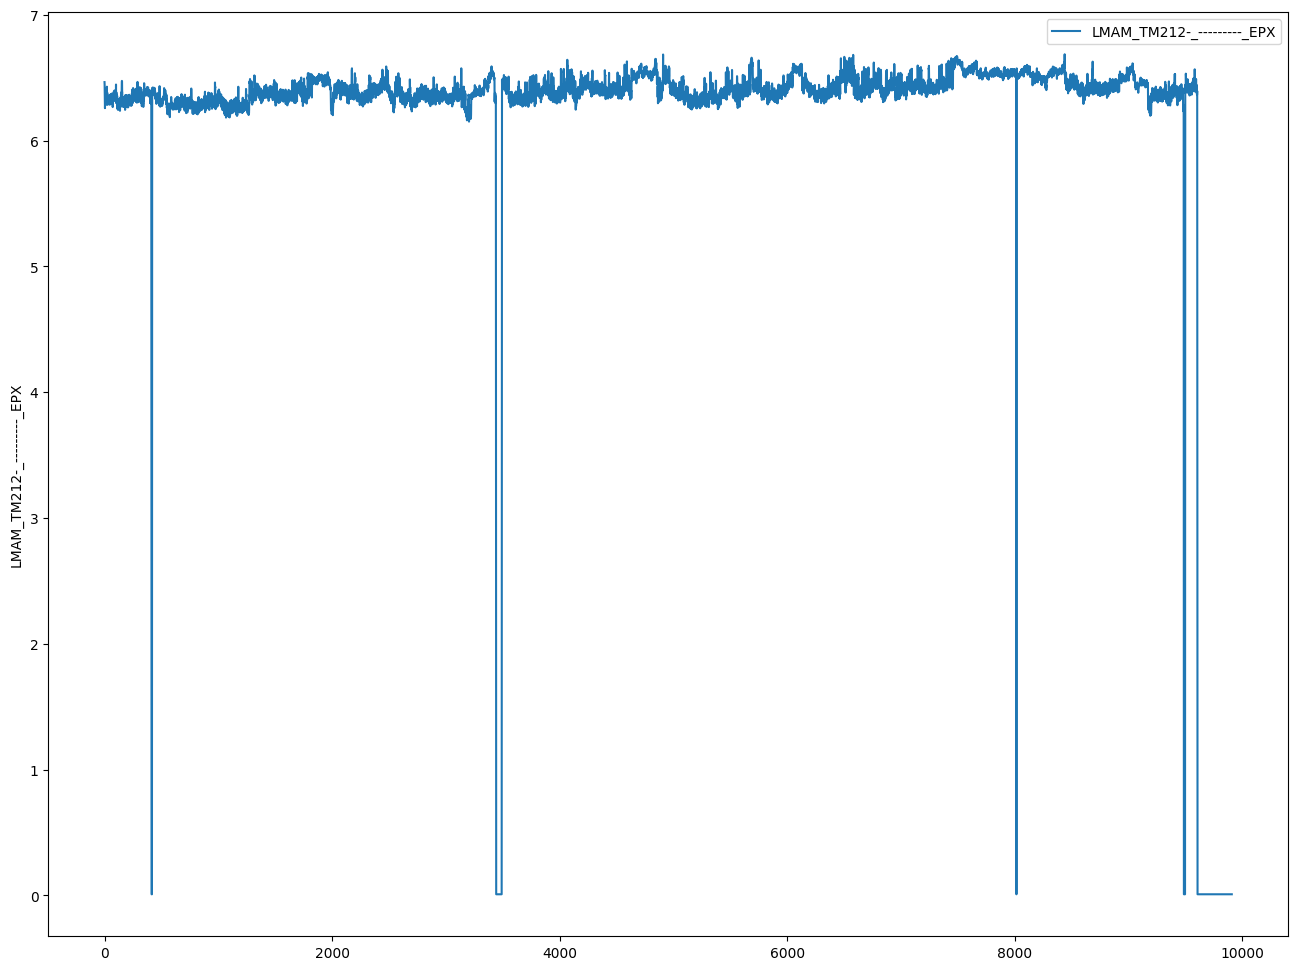

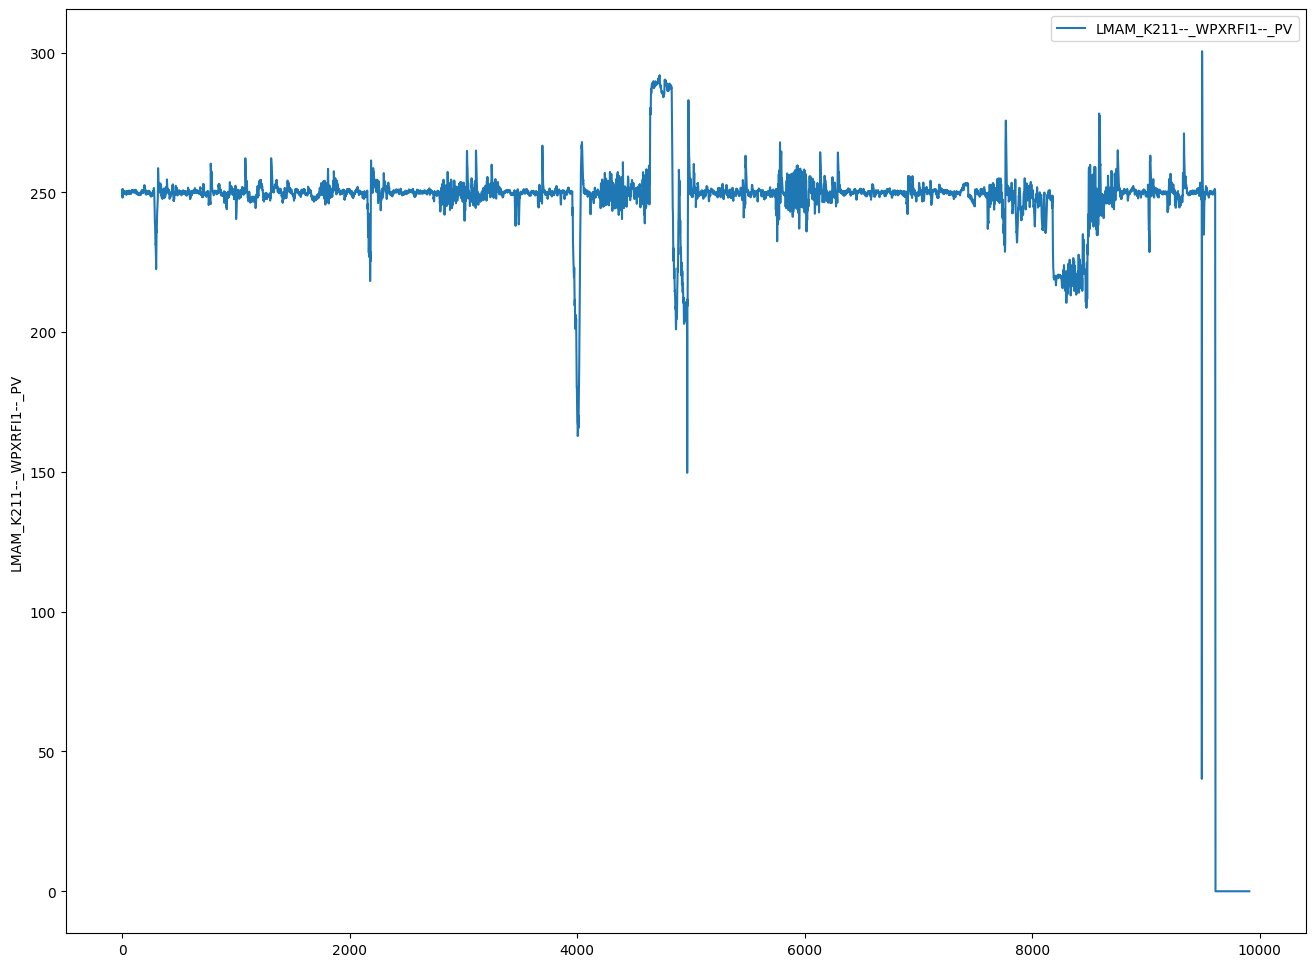

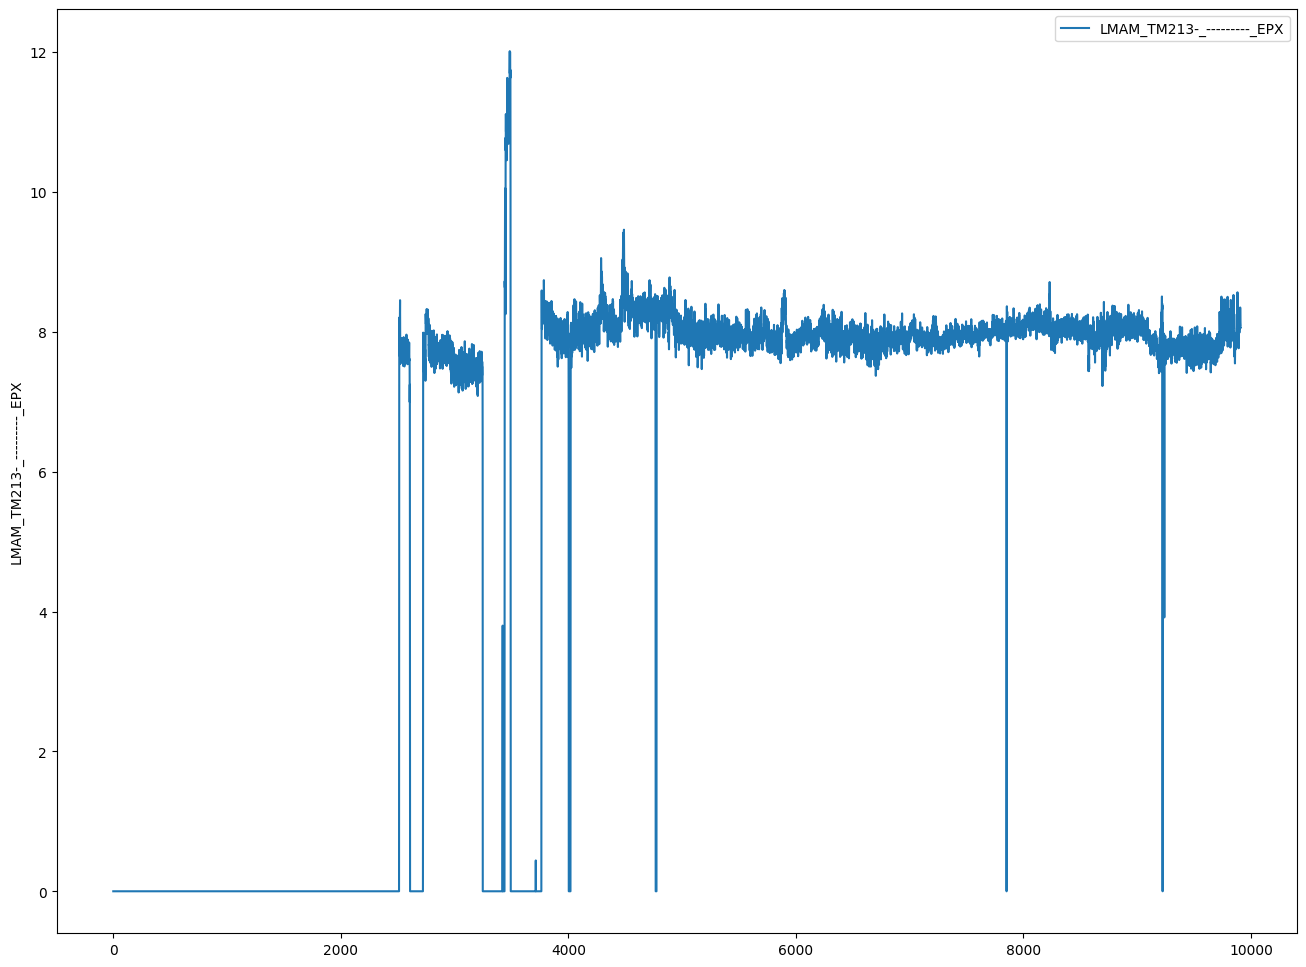

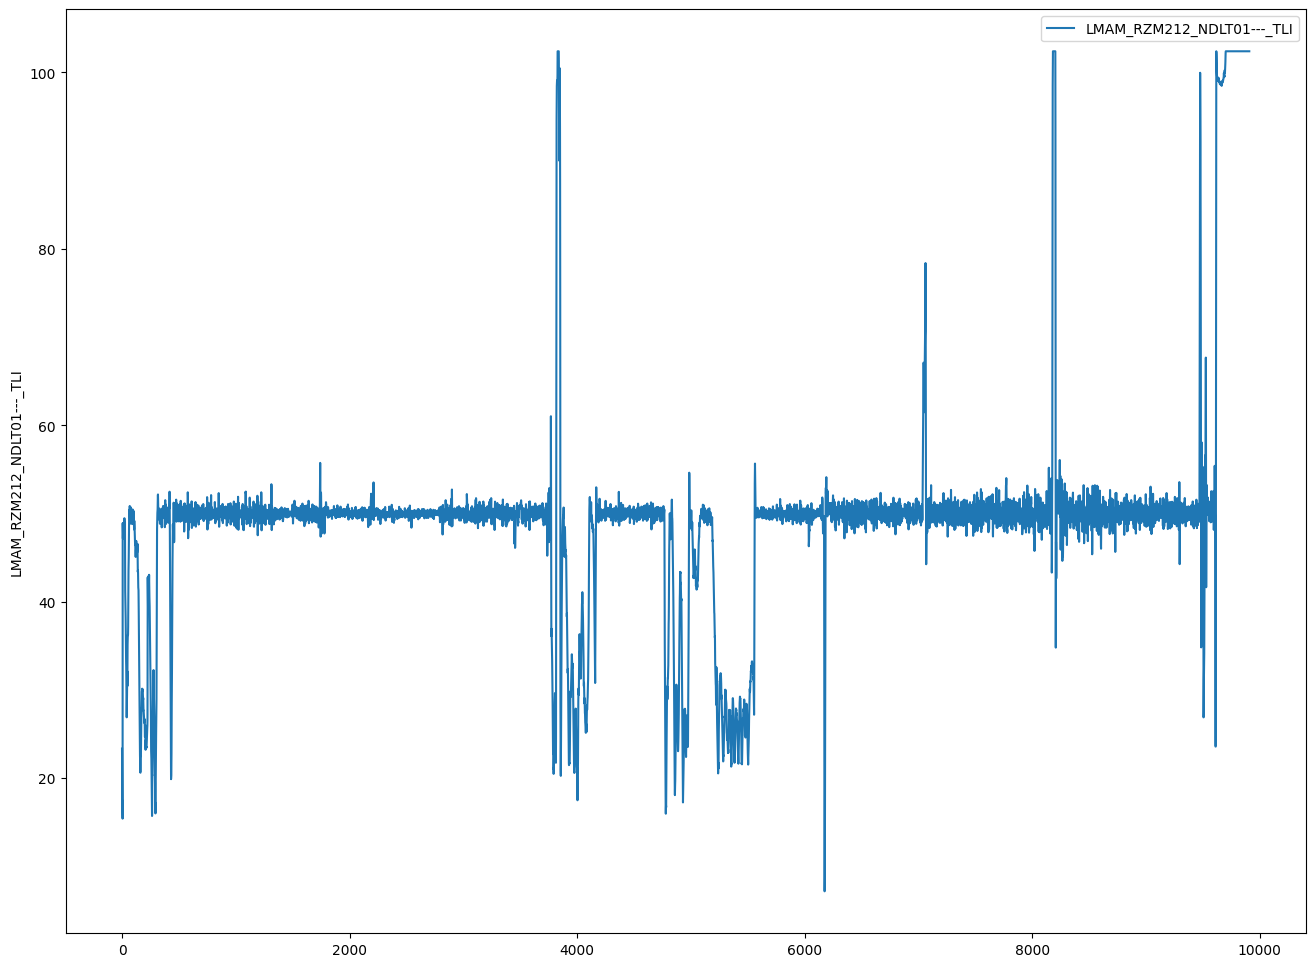

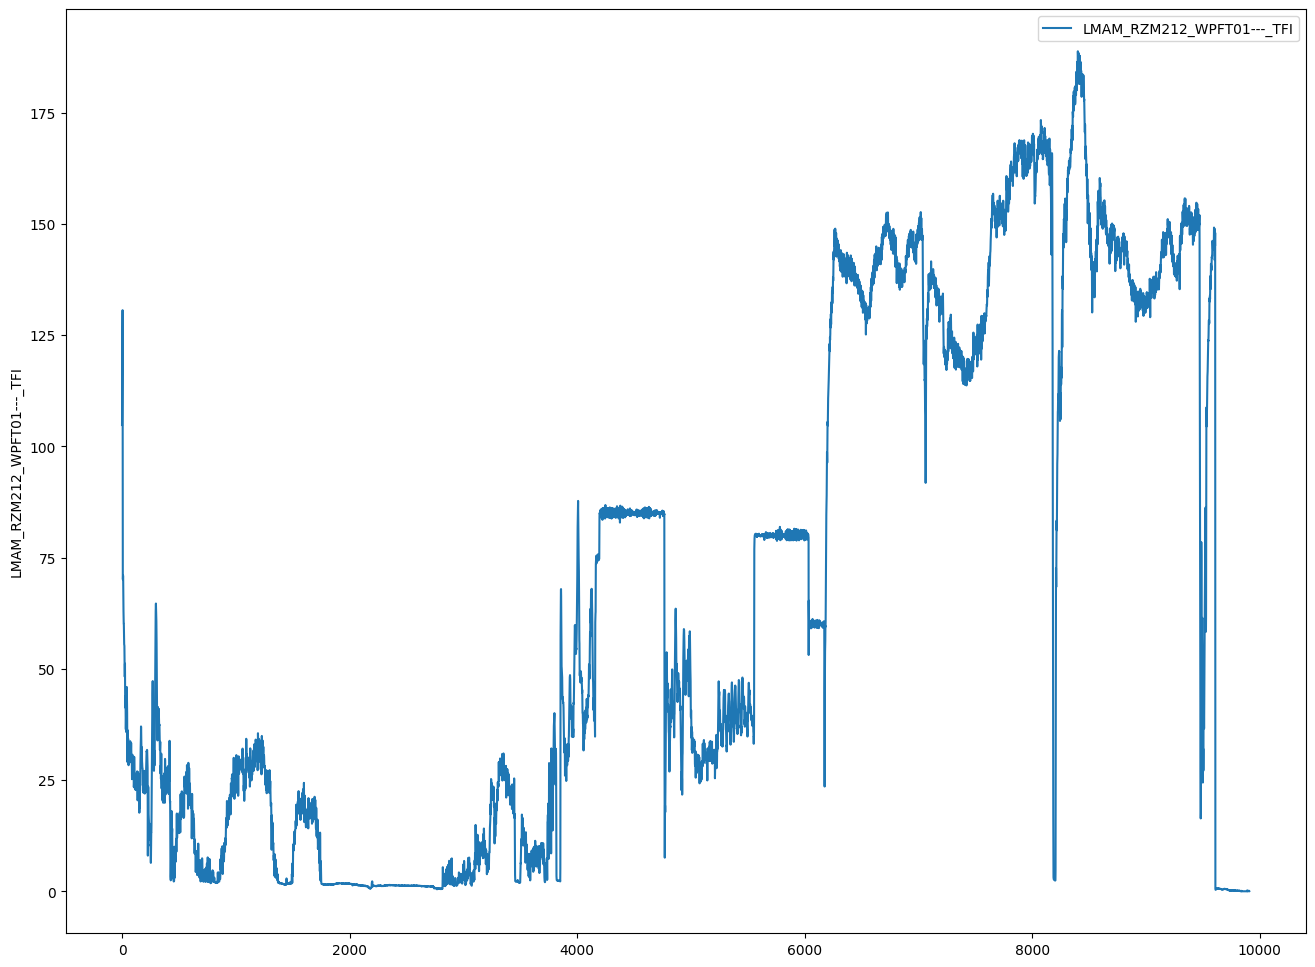

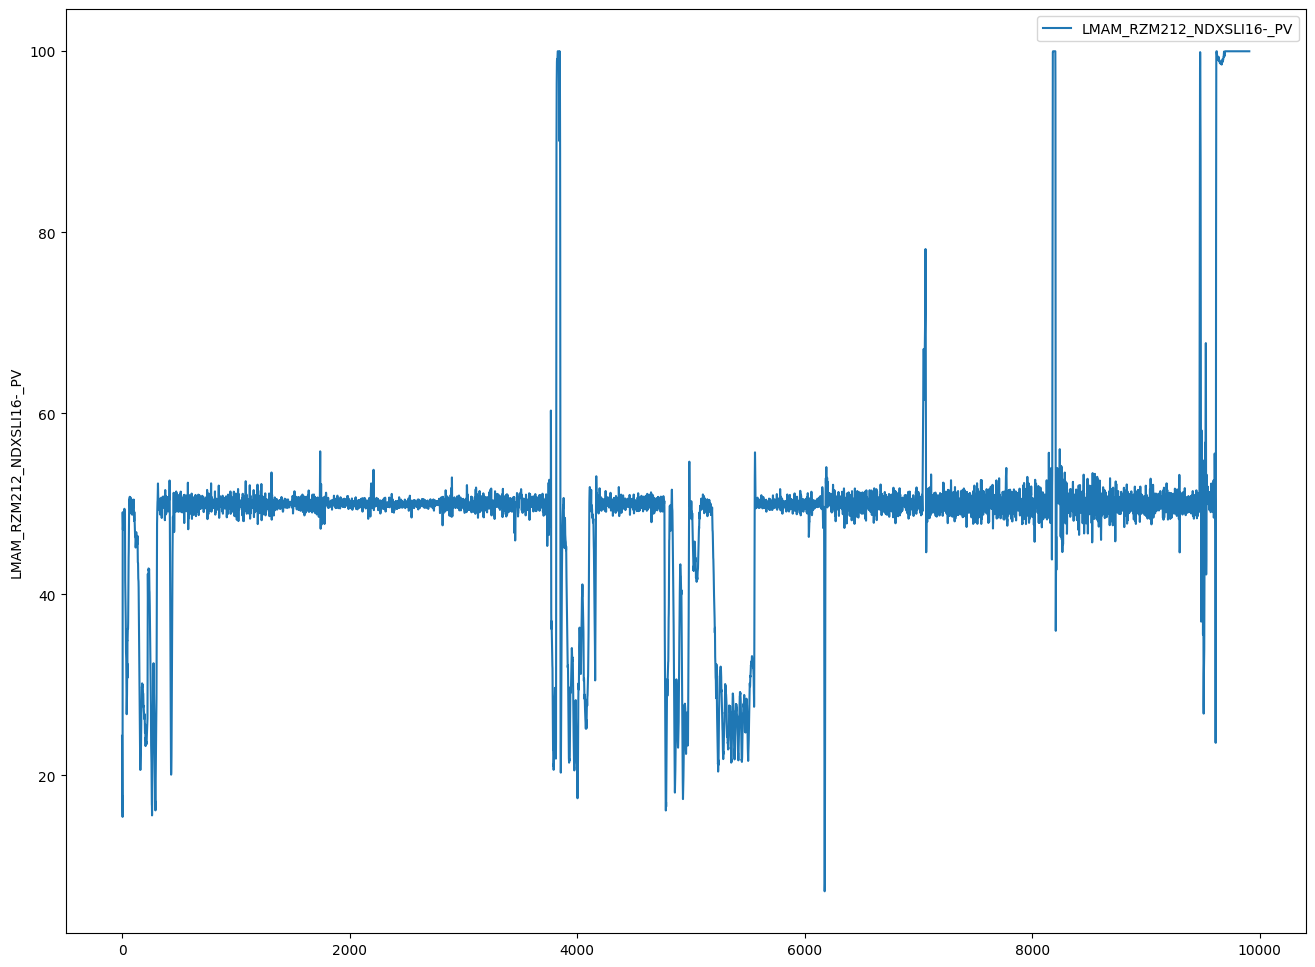

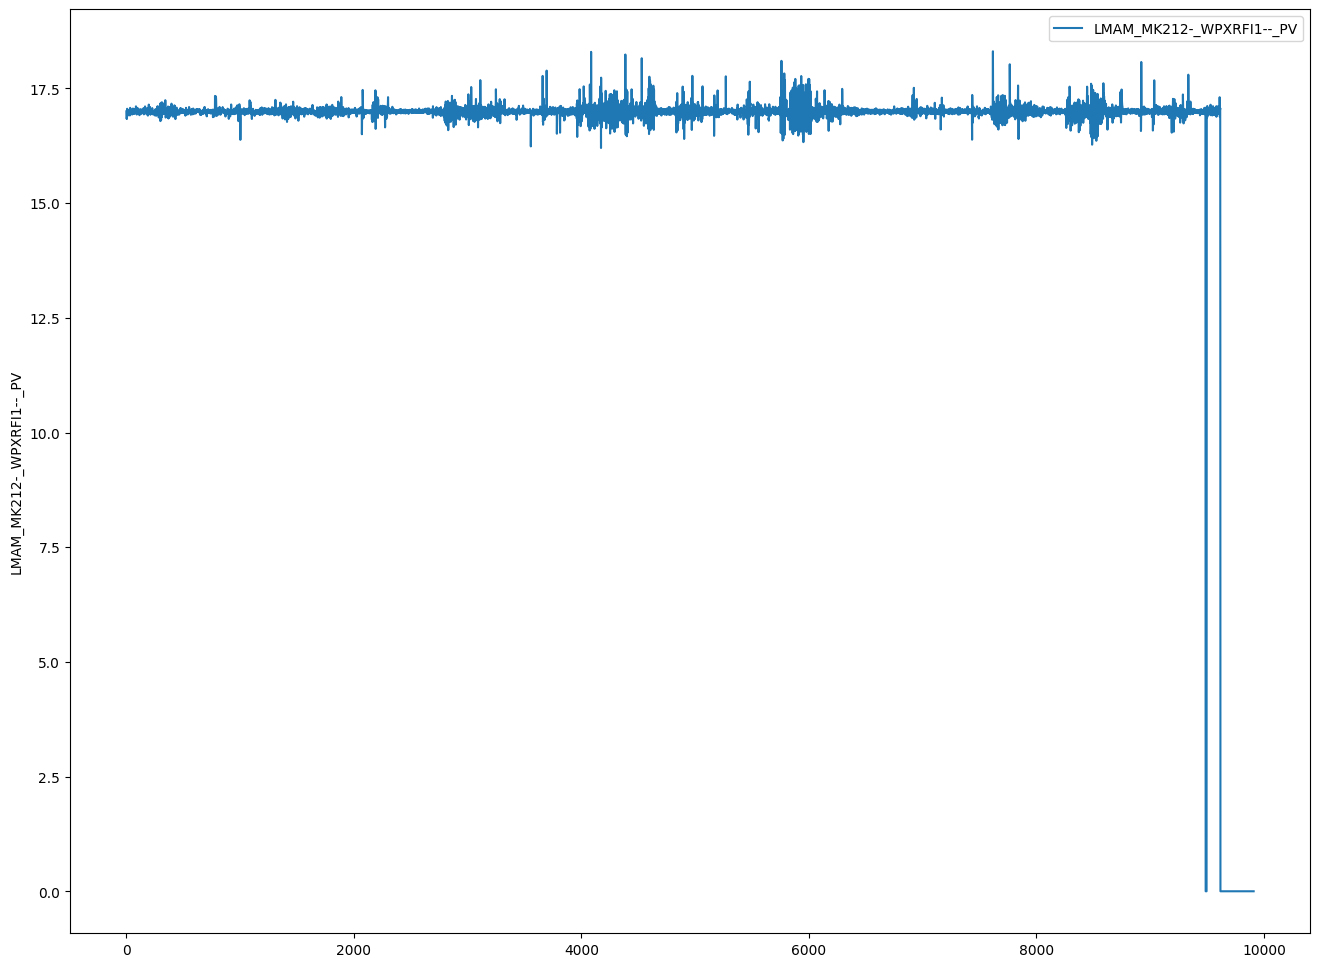

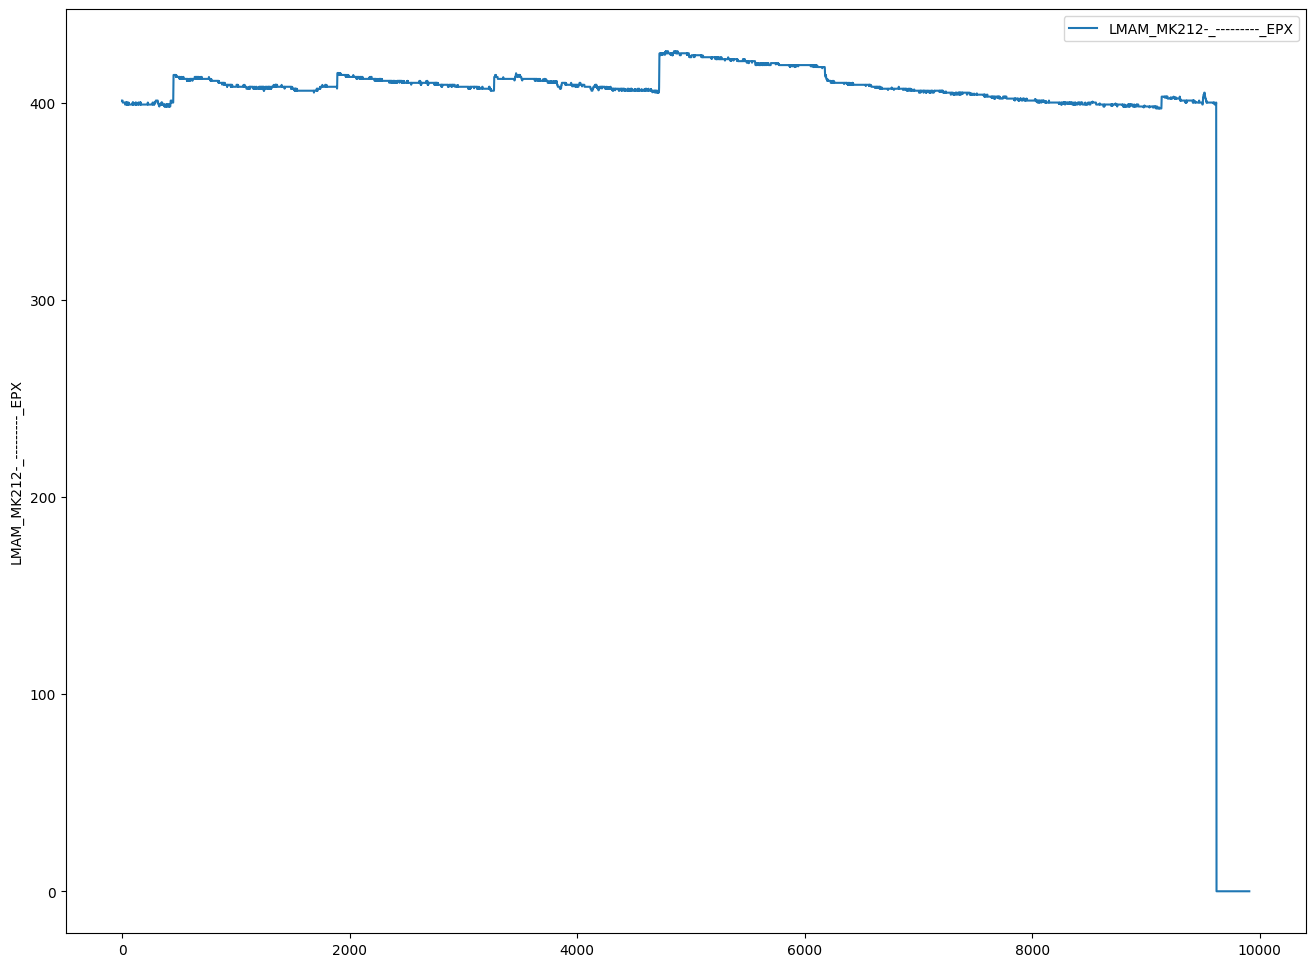

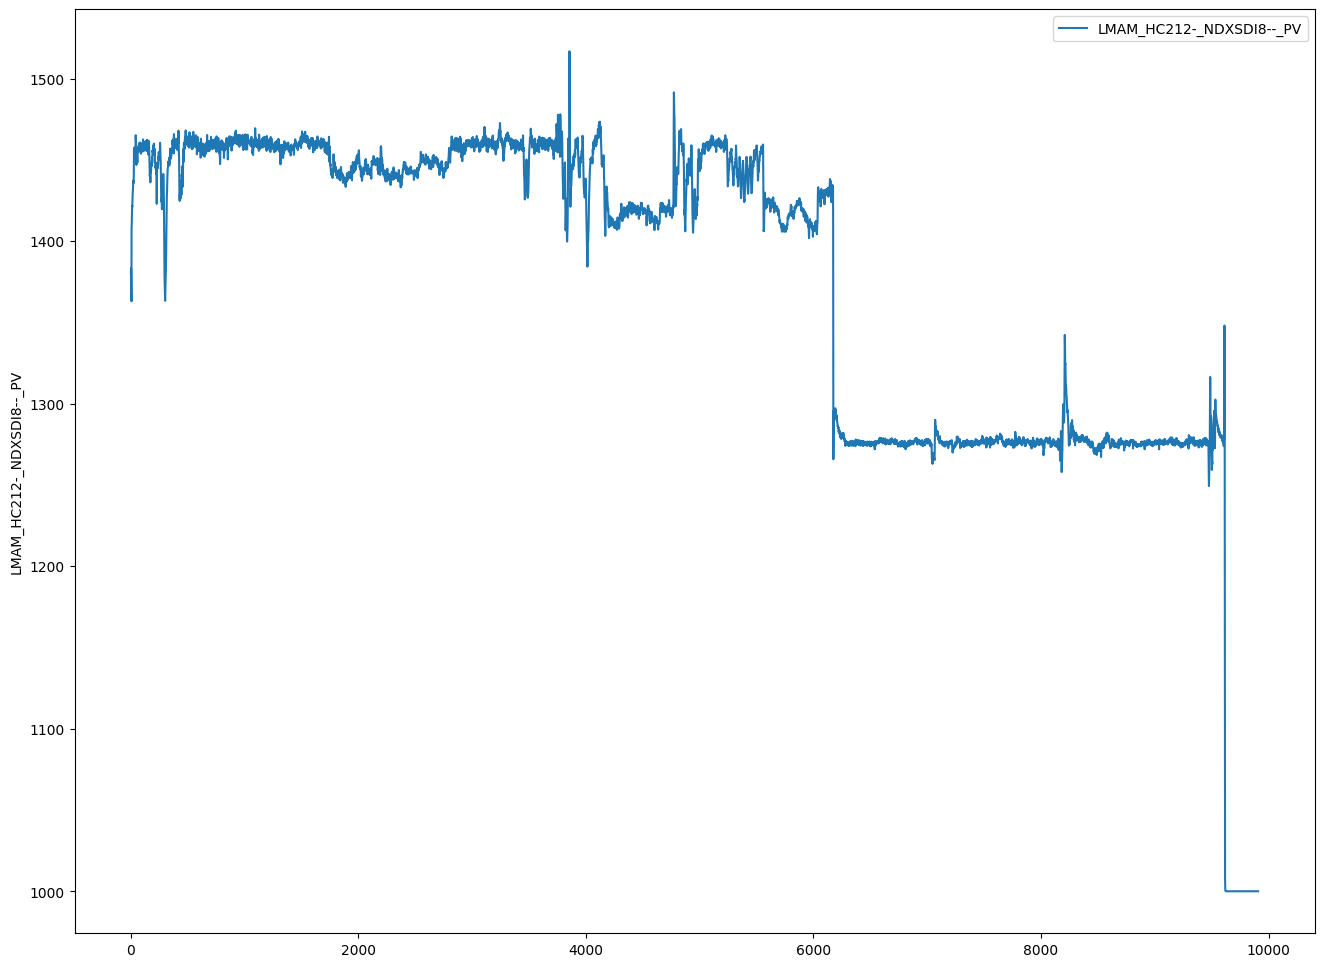

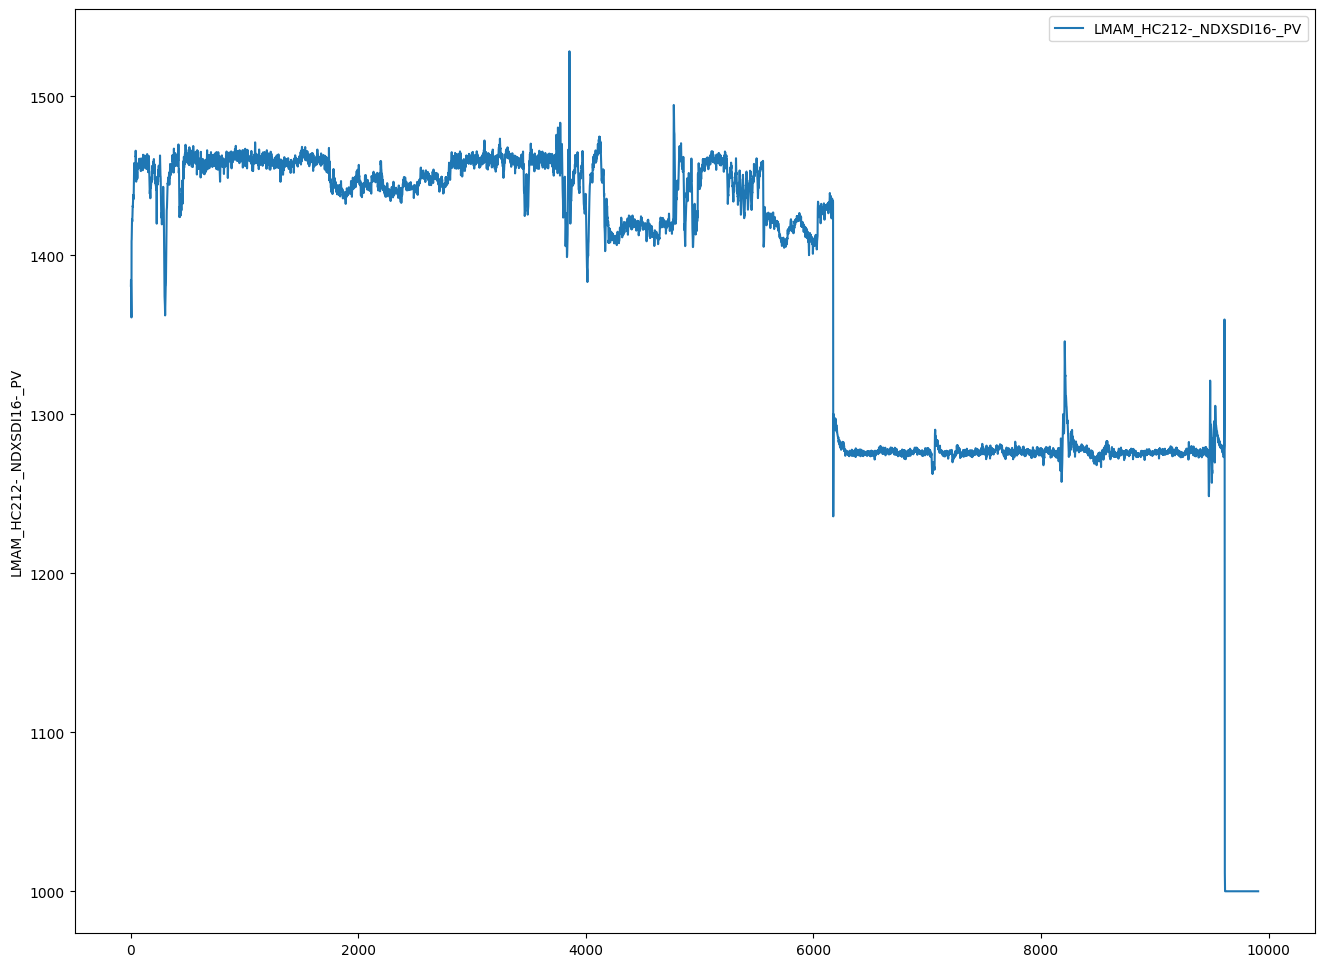

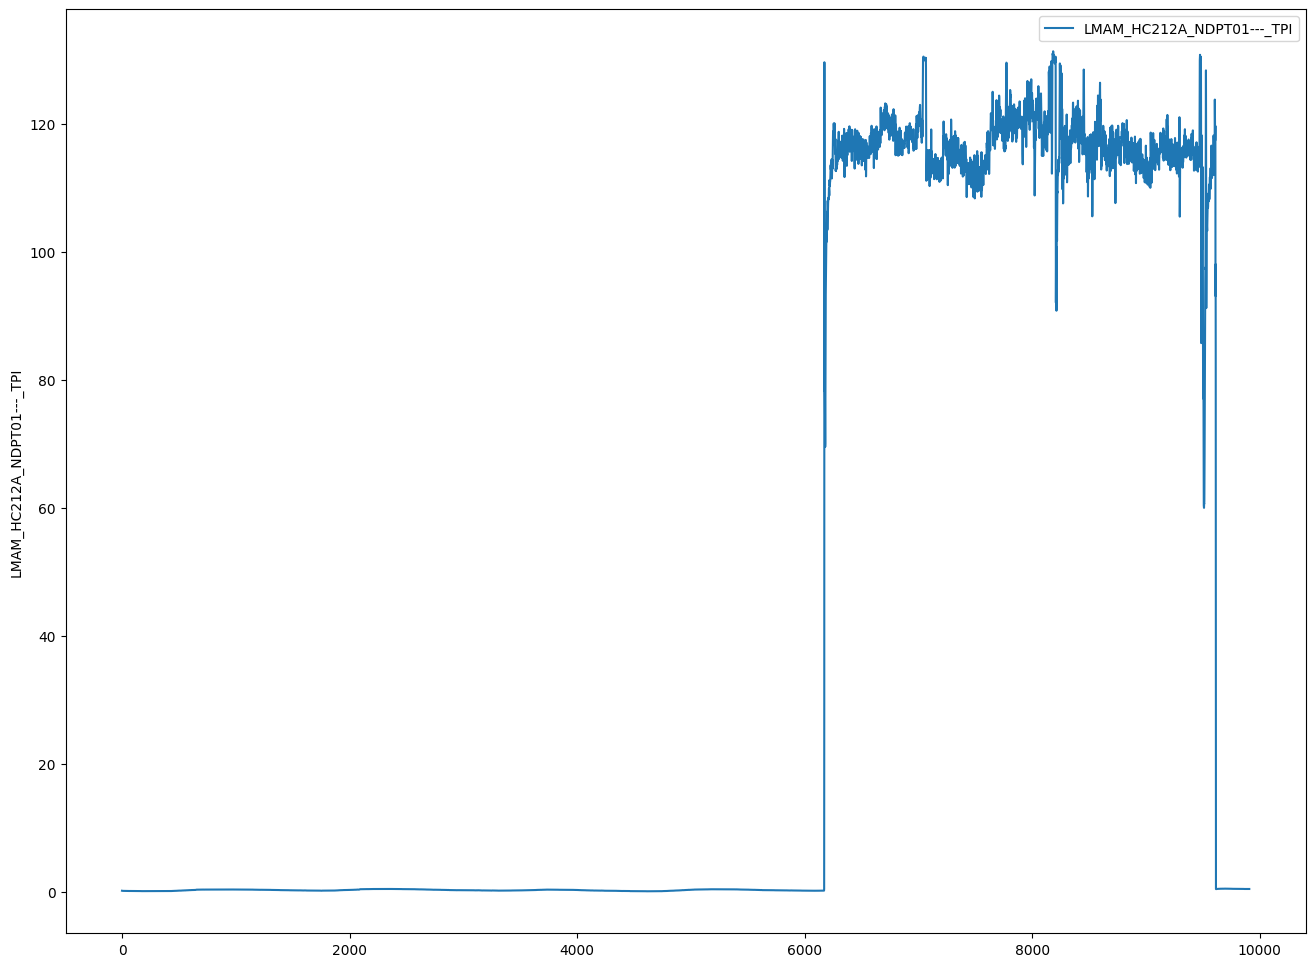

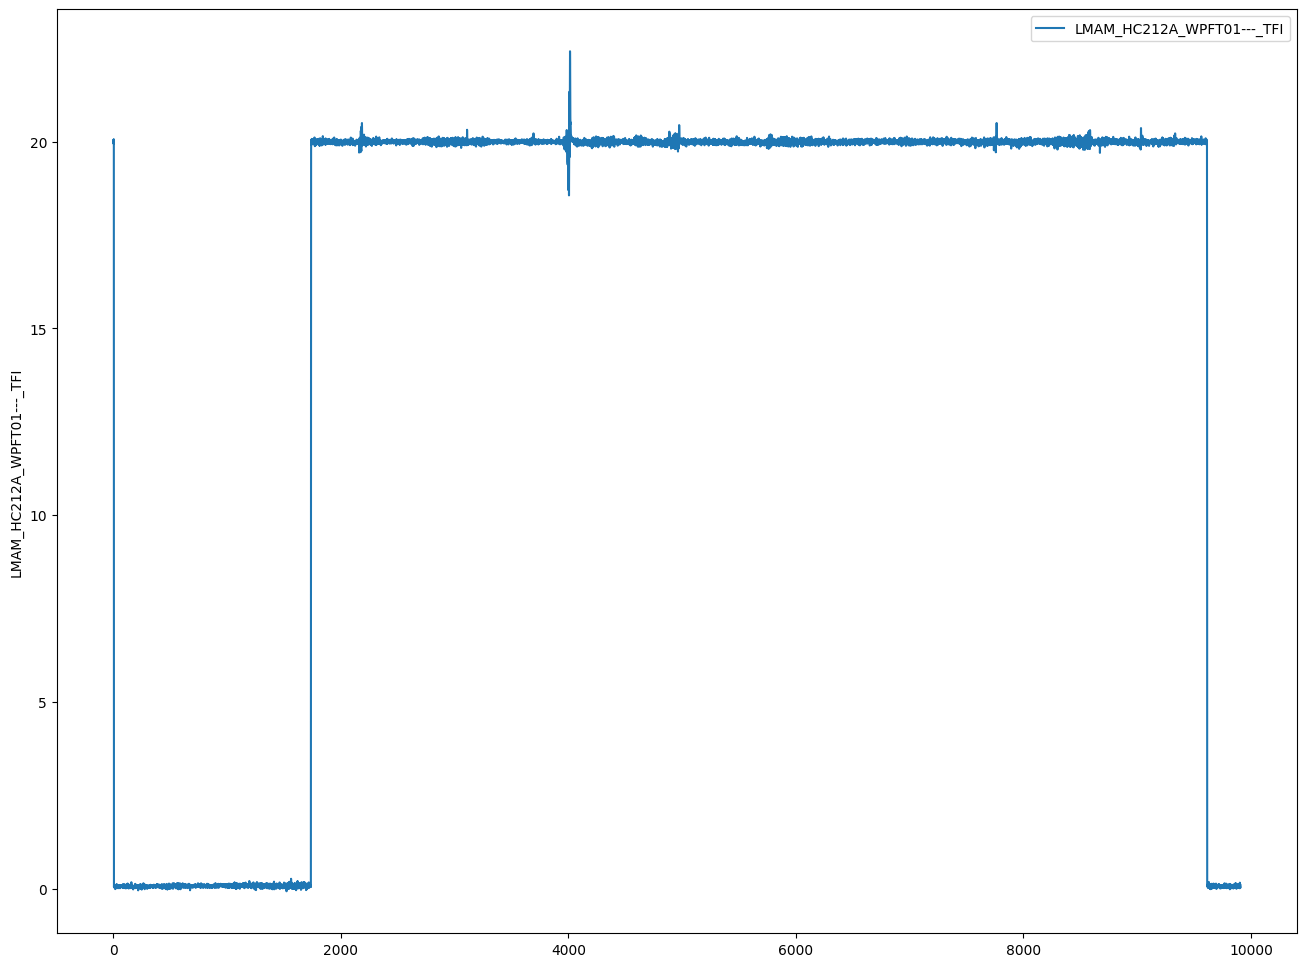

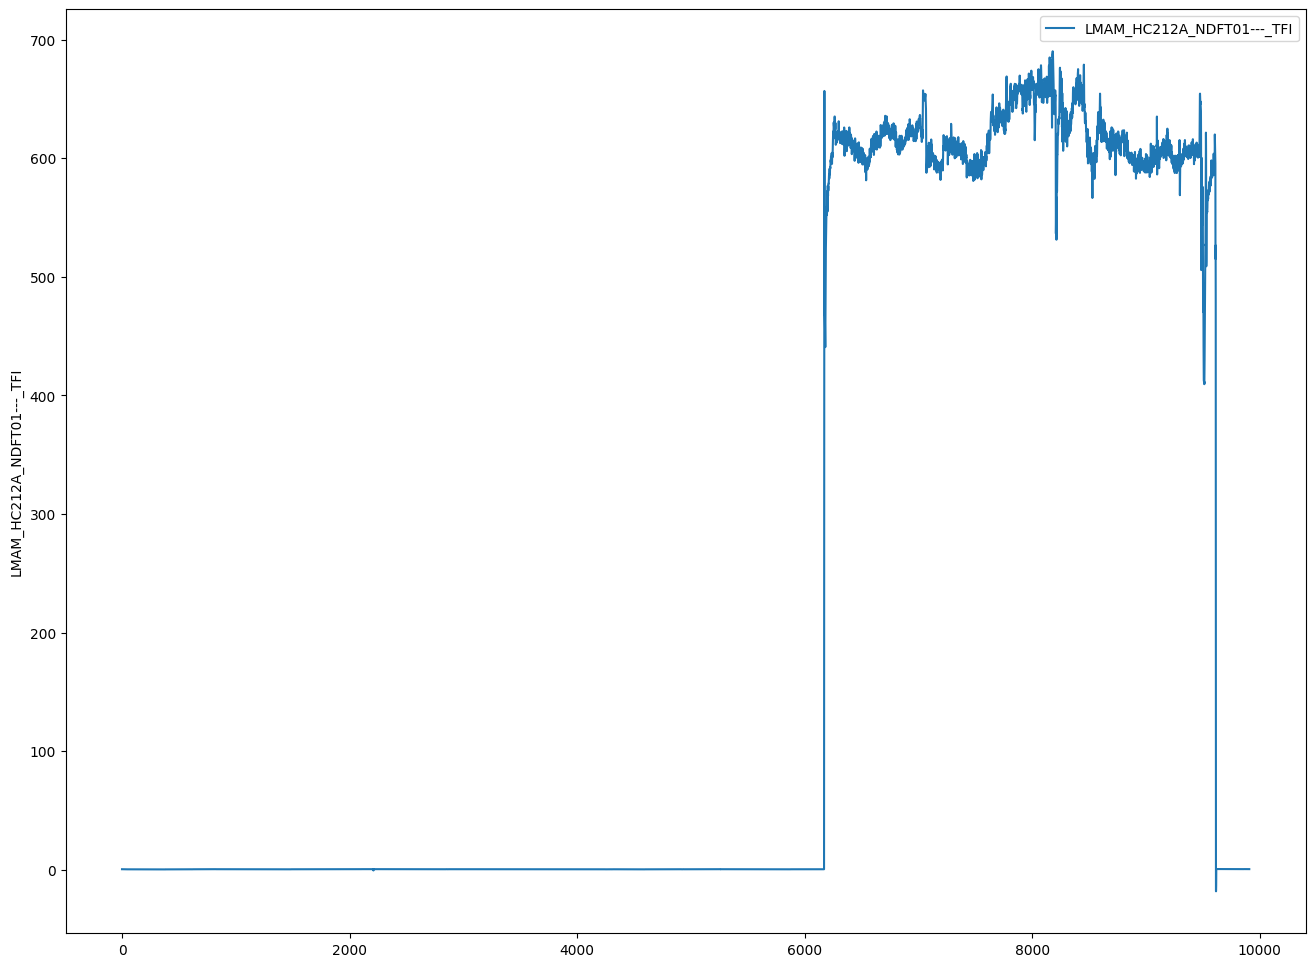

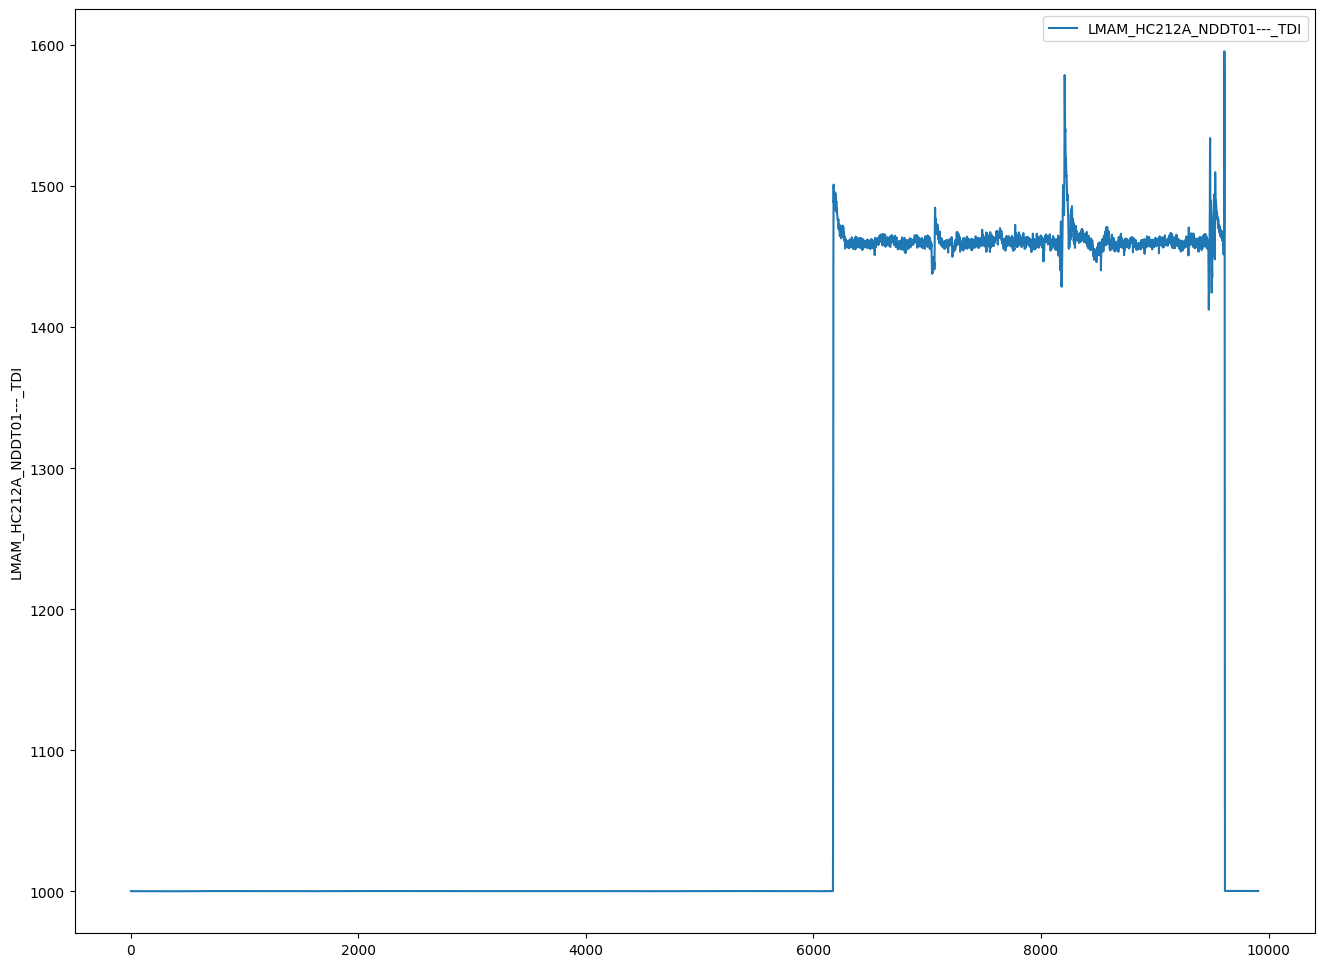

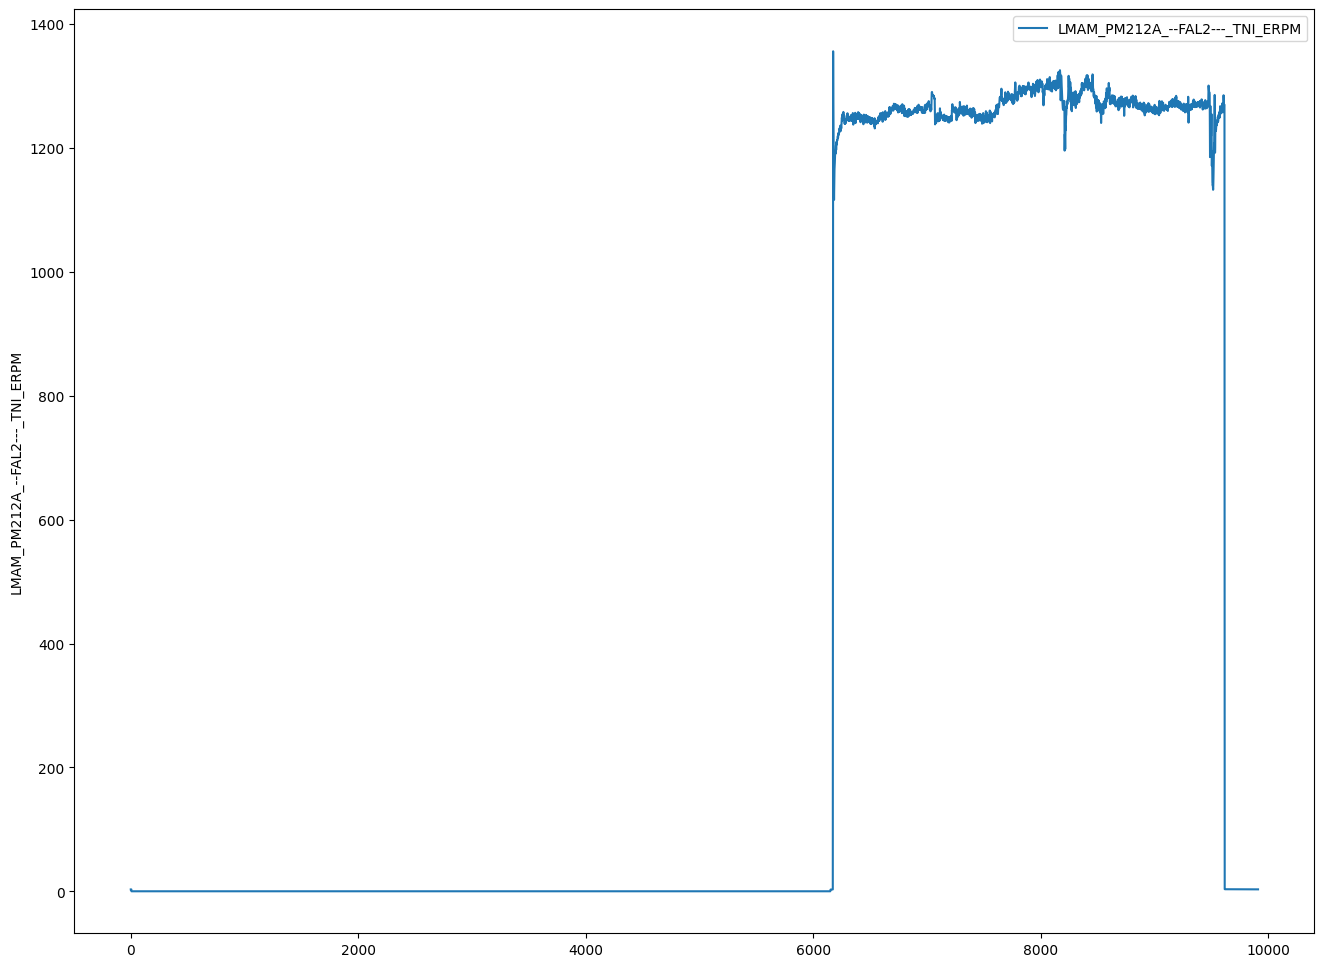

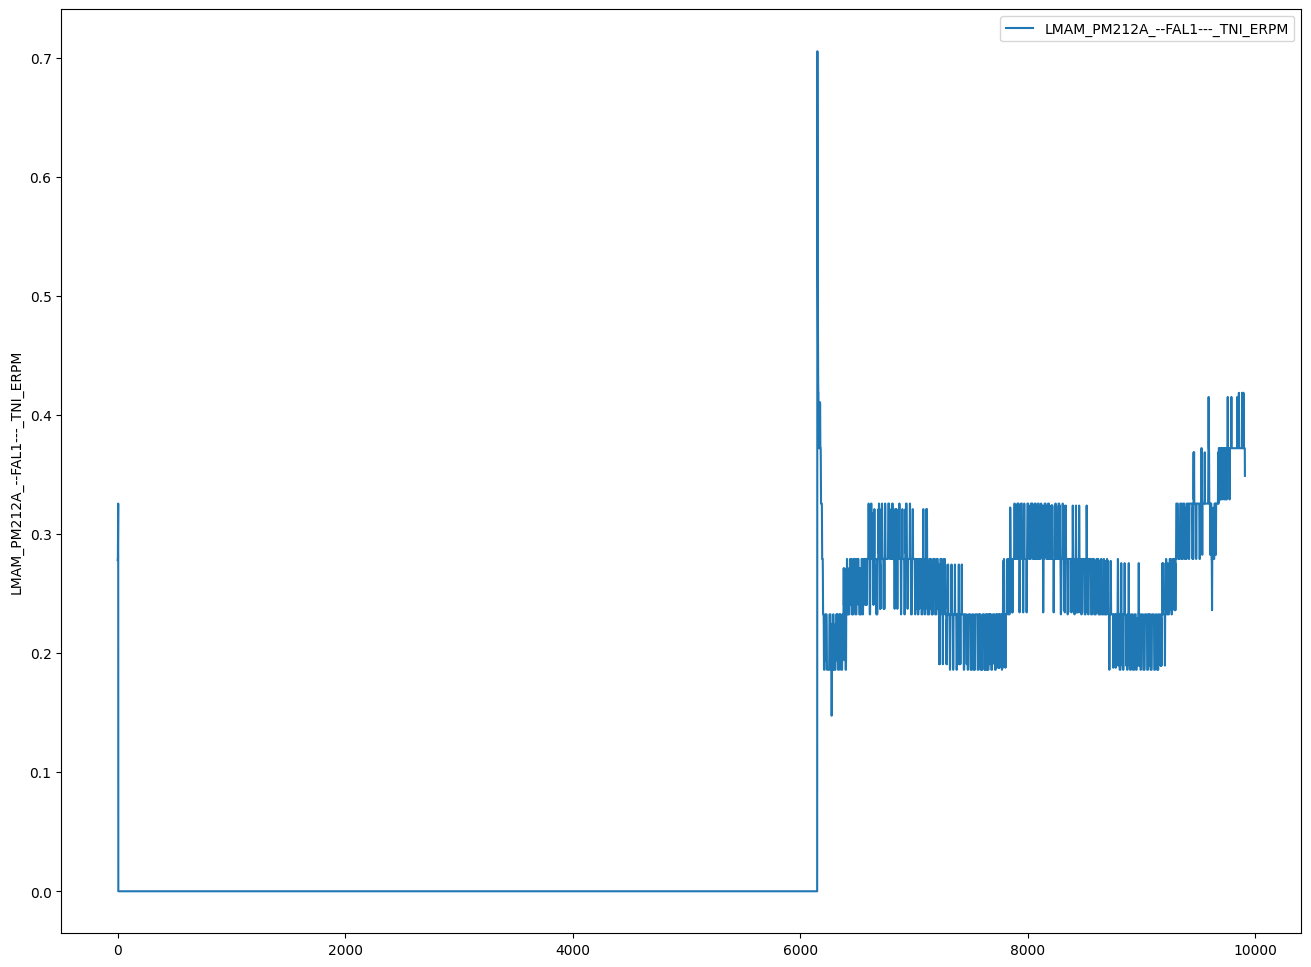

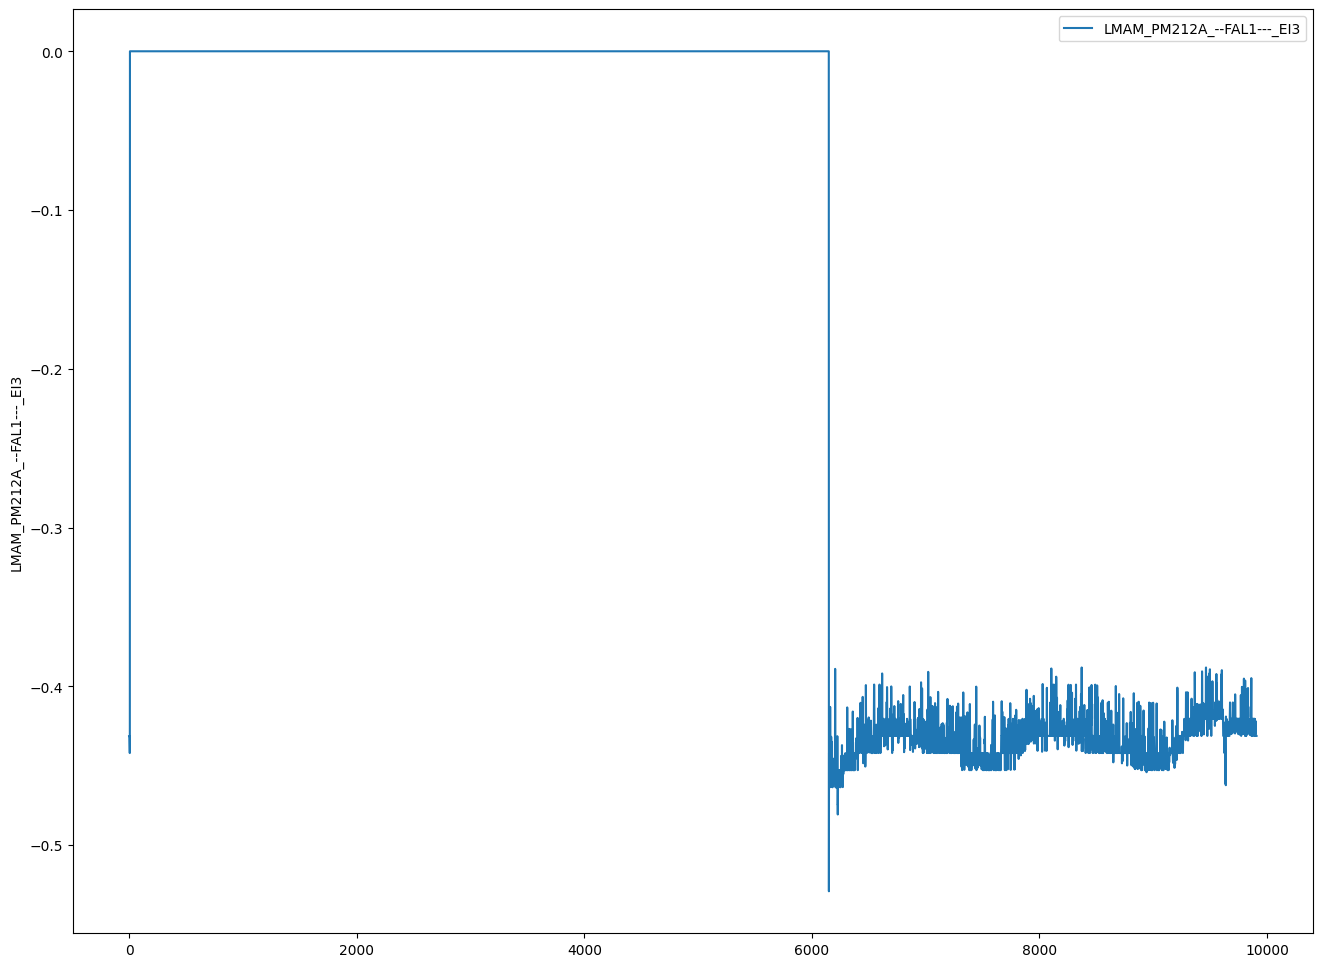

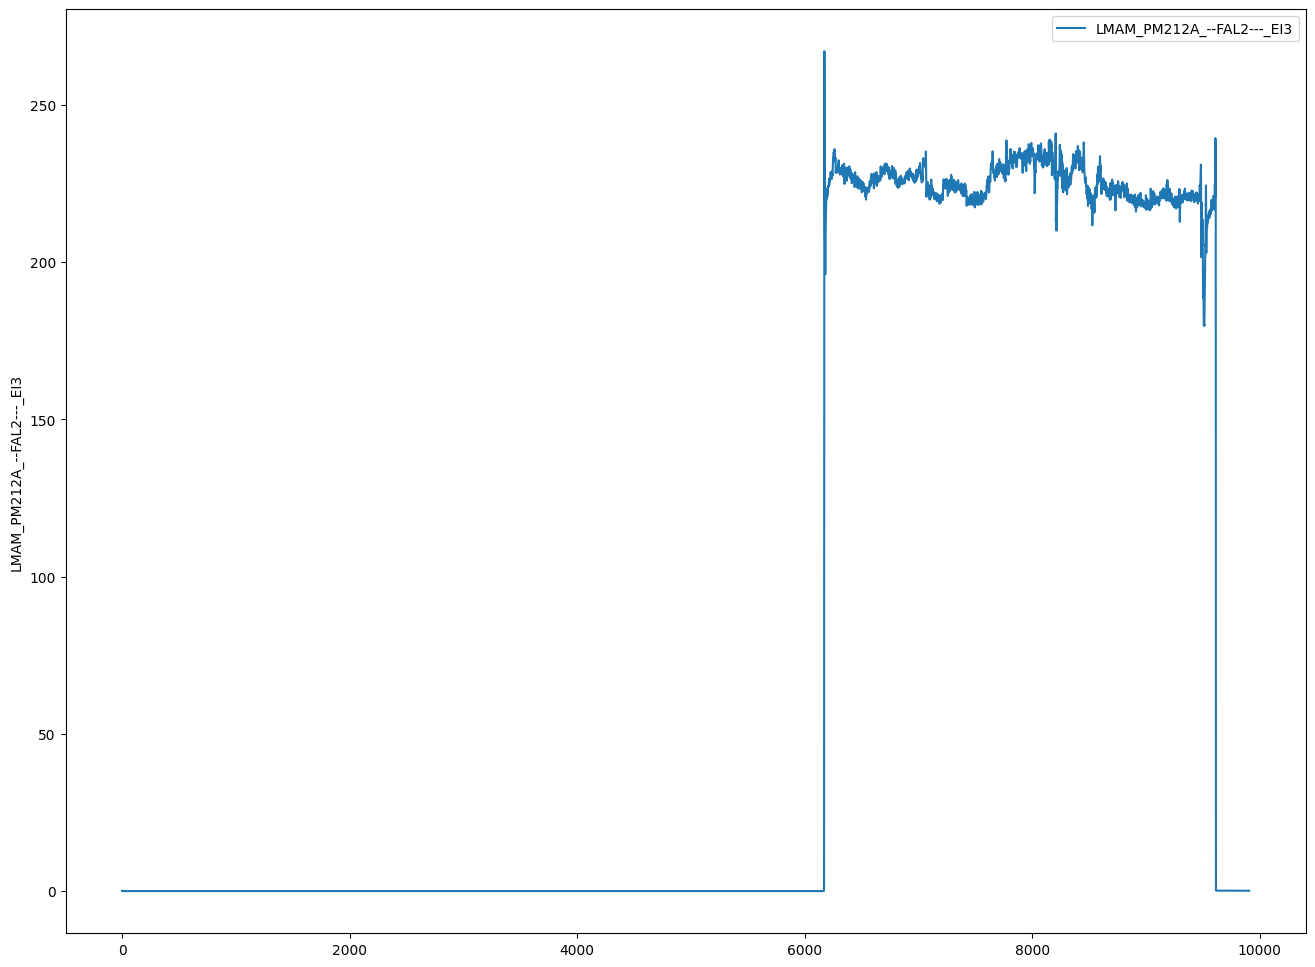

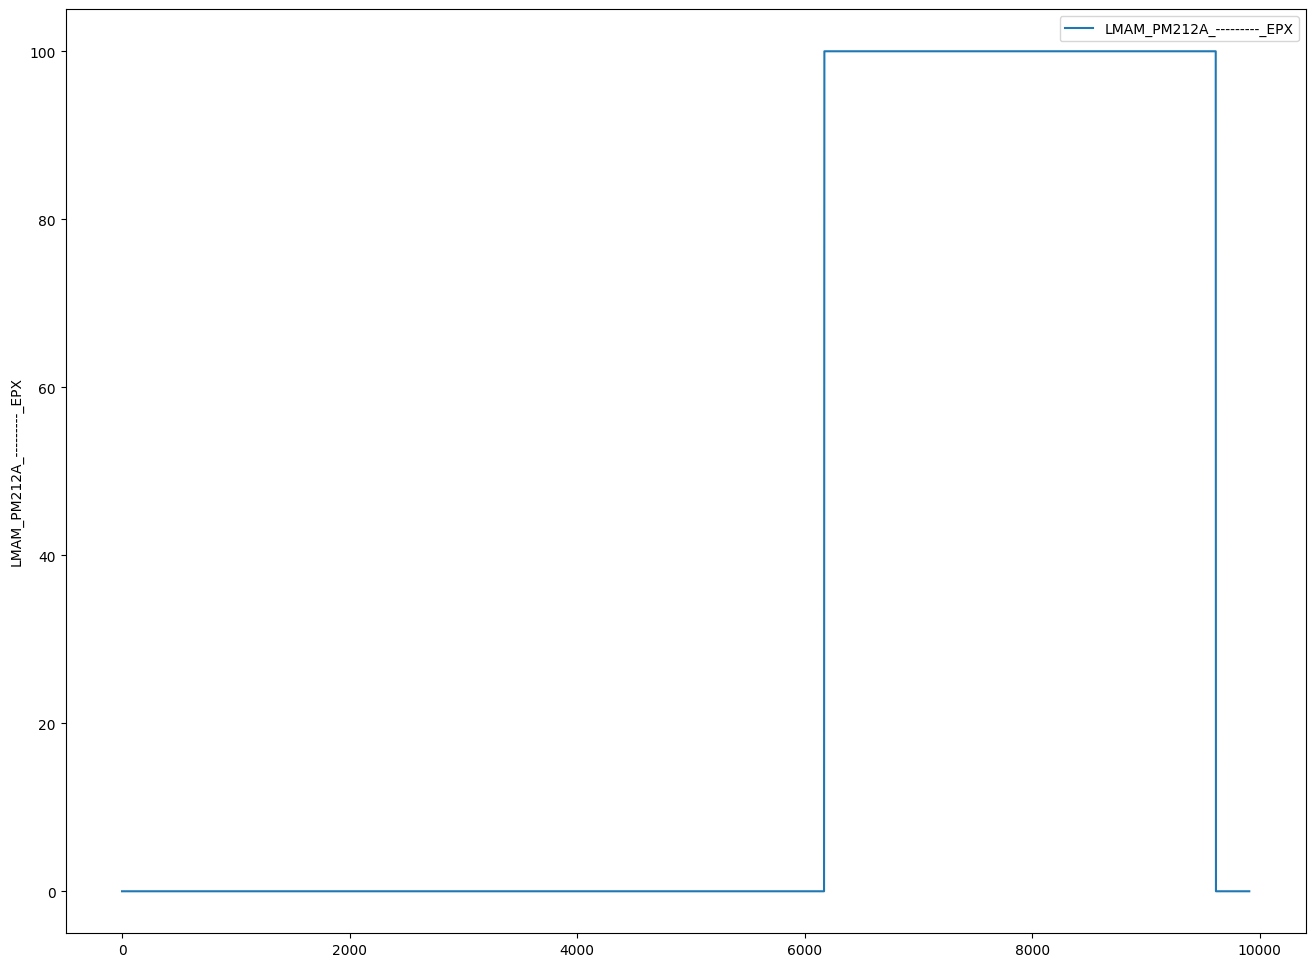

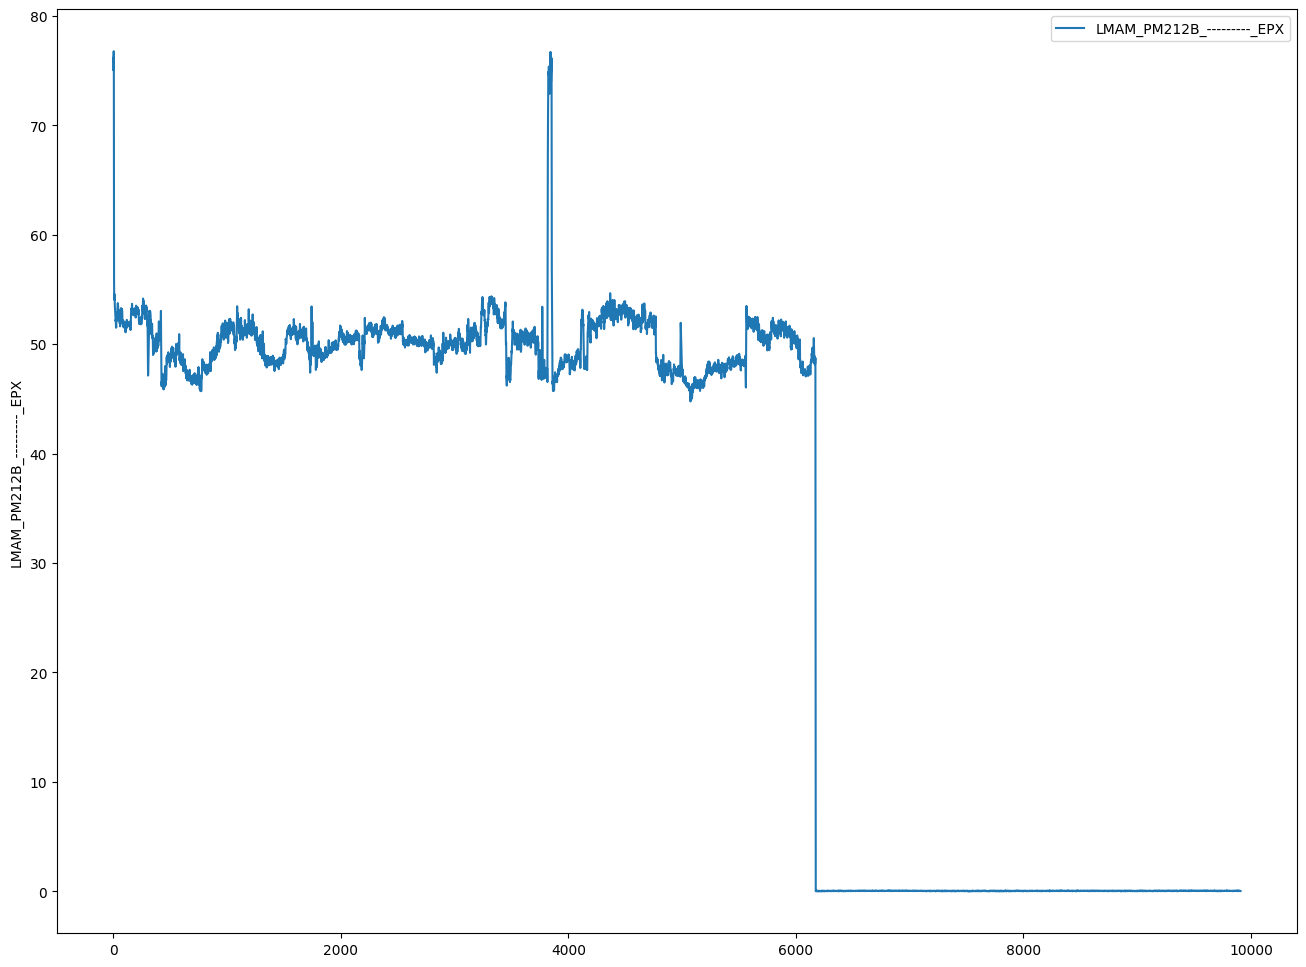

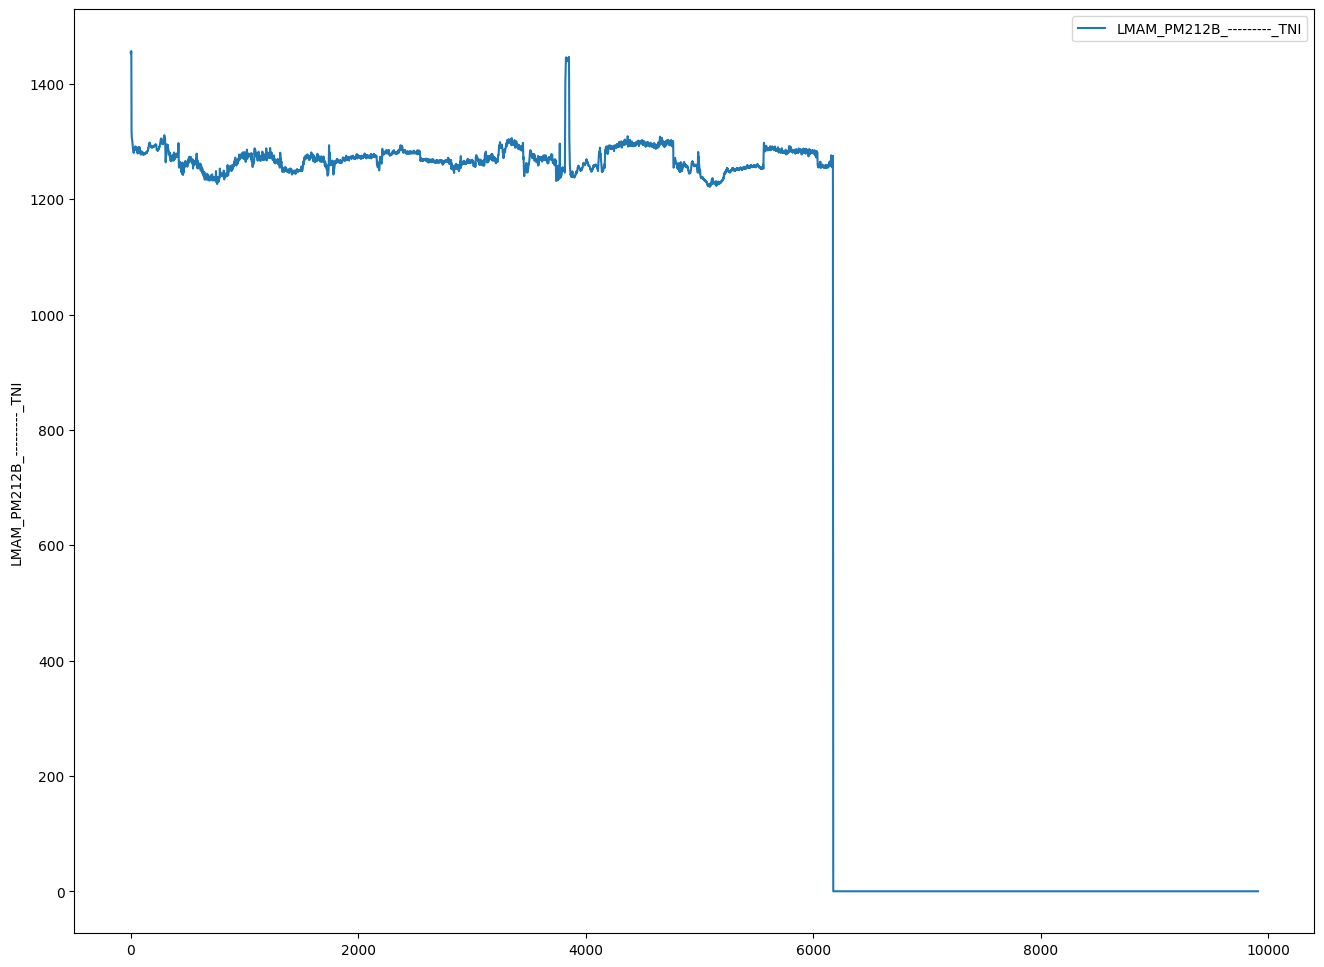

In [29]:
for i, col in enumerate(df.columns):
    fig = plt.figure(figsize=(16,12))
    plt.plot(range(len(df)), df[col], label=col)
    plt.ylabel(col)
    plt.legend()
    plt.savefig(f'images/{i}_{col}.png')


In [18]:
columns = df.columns.to_list()[:-1]
print(columns)

['LMAM_OBM1C2_WPPT01---_TPI', 'LMAM_MP211-_RDXRFI2--_PV', 'LMAM_MP211-_---------_EPX', 'LMAM_MP211-_RDXRFI1--_PV', 'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_TM141-_RDFQ01---_TFI', 'LMAM_TM211-_---------_EPX', 'LMAM_TM212-_---------_EPX', 'LMAM_K211--_WPXRFI1--_PV', 'LMAM_TM213-_---------_EPX', 'LMAM_RZM212_NDLT01---_TLI', 'LMAM_RZM212_WPFT01---_TFI', 'LMAM_RZM212_NDXSLI16-_PV', 'LMAM_MK212-_WPXRFI1--_PV', 'LMAM_MK212-_---------_EPX', 'LMAM_HC212-_NDXSDI8--_PV', 'LMAM_HC212-_NDXSDI16-_PV', 'LMAM_HC212A_NDPT01---_TPI', 'LMAM_HC212A_WPFT01---_TFI', 'LMAM_HC212A_NDFT01---_TFI', 'LMAM_HC212A_NDDT01---_TDI', 'LMAM_PM212A_--FAL2---_TNI_ERPM', 'LMAM_PM212A_--FAL1---_TNI_ERPM', 'LMAM_PM212A_--FAL1---_EI3', 'LMAM_PM212A_--FAL2---_EI3', 'LMAM_PM212A_---------_EPX', 'LMAM_PM212B_---------_EPX', 'LMAM_PM212B_---------_TNI']


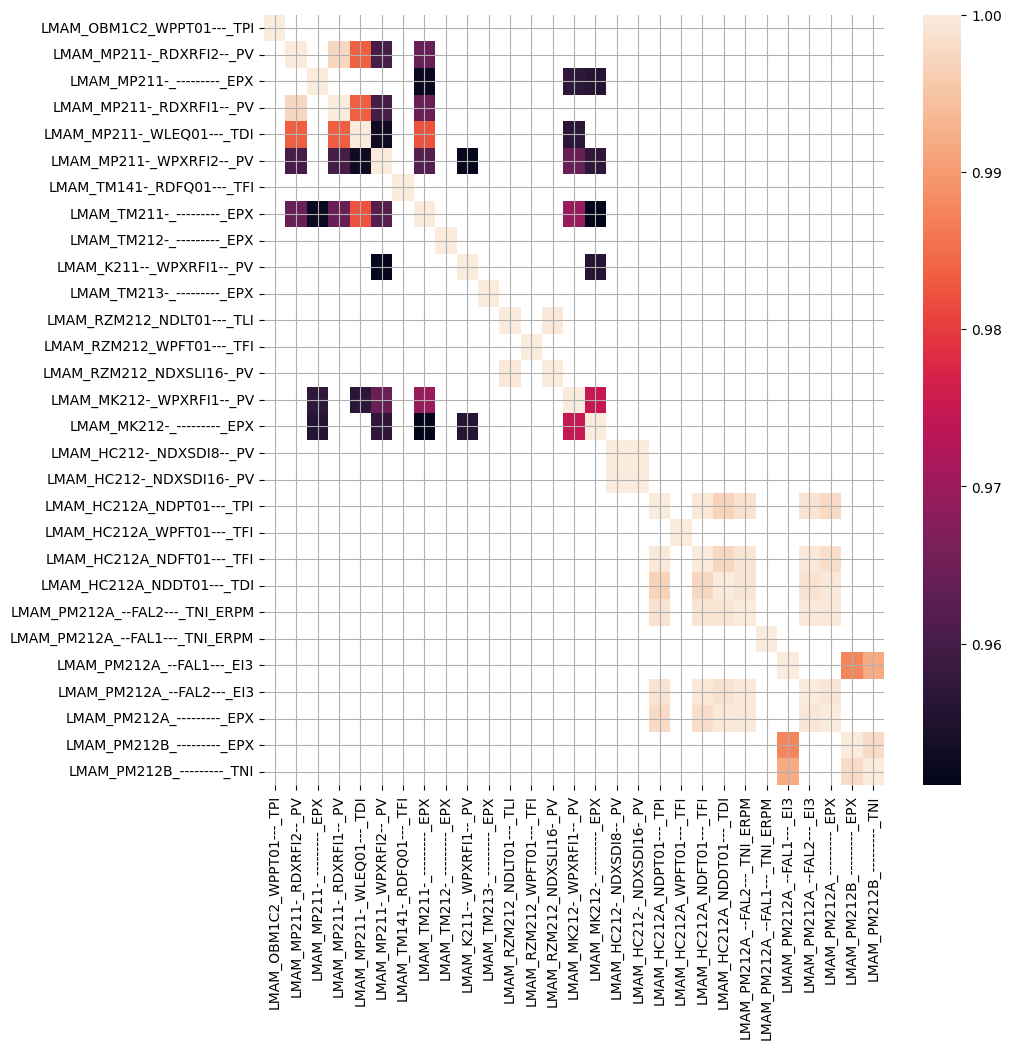

In [19]:
import seaborn as sns

df = df.drop(columns=y_name)
correlations = df.corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(correlations[correlations > 0.95])
plt.grid()

In [20]:
highly_corr_mask = correlations[correlations > 0.90]

correlated_dic = {}

for i, row in enumerate(highly_corr_mask.values):
    correlated_columns = correlations.columns.to_numpy()[row > 0].tolist()
    index_column = correlations.index.to_numpy()[i]
    correlated_columns.remove(index_column)
    
    if len(correlated_columns) > 0 and i < i*2:
        correlated_dic[index_column] = correlated_columns

print(correlated_dic)
print(len(correlated_dic))
import json 
with open('highly_correlated.json', 'w') as f:
    json.dump(correlated_dic, f, indent=1)

{'LMAM_MP211-_RDXRFI2--_PV': ['LMAM_MP211-_---------_EPX', 'LMAM_MP211-_RDXRFI1--_PV', 'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_TM211-_---------_EPX', 'LMAM_TM212-_---------_EPX', 'LMAM_K211--_WPXRFI1--_PV', 'LMAM_MK212-_WPXRFI1--_PV', 'LMAM_MK212-_---------_EPX'], 'LMAM_MP211-_---------_EPX': ['LMAM_MP211-_RDXRFI2--_PV', 'LMAM_MP211-_RDXRFI1--_PV', 'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_TM211-_---------_EPX', 'LMAM_K211--_WPXRFI1--_PV', 'LMAM_MK212-_WPXRFI1--_PV', 'LMAM_MK212-_---------_EPX'], 'LMAM_MP211-_RDXRFI1--_PV': ['LMAM_MP211-_RDXRFI2--_PV', 'LMAM_MP211-_---------_EPX', 'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_TM211-_---------_EPX', 'LMAM_TM212-_---------_EPX', 'LMAM_K211--_WPXRFI1--_PV', 'LMAM_MK212-_WPXRFI1--_PV', 'LMAM_MK212-_---------_EPX'], 'LMAM_MP211-_WLEQ01---_TDI': ['LMAM_MP211-_RDXRFI2--_PV', 'LMAM_MP211-_---------_EPX', 'LMAM_MP211-_RDXRFI1--_PV', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_TM211-_---------_E

In [5]:
# with open('labels.txt', 'r') as f:
#     labels = f.readlines()

# stripped = dict()
# for lab in labels:
#     _id, name = lab.split('\t')
#     stripped[_id] = name[:len(name)-1]


# stripped = np.array(stripped)

In [6]:
#PLOT CORRELATED

# fig, ax =plt.subplots(nrows=4, ncols=4, figsize=(18,14))
# ax = ax.flatten()

# i = 0
# for c, (key, _list_of_corr) in enumerate(correlated_dic.items()):
#     for corr in _list_of_corr:
#         ax[i].plot(range(len(df)), df[key], label=key)
#         ax[i].plot(range(len(df)), df[corr], label=corr)
#         ax[i].legend()

#         i+=1

# plt.tight_layout()
# plt.show()

In [21]:
from utils import utils

cols_to_drop = utils.get_highly_correlated_columns_to_remove(correlated_dict=correlated_dic)

clean_df = df.drop(columns=cols_to_drop)
print(len(clean_df.columns))
clean_df.columns

To remove:  {'LMAM_MP211-_---------_EPX', 'LMAM_K211--_WPXRFI1--_PV', 'LMAM_MP211-_RDXRFI2--_PV', 'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_PM212A_---------_EPX', 'LMAM_PM212B_---------_TNI', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_HC212-_NDXSDI16-_PV', 'LMAM_MP211-_RDXRFI1--_PV', 'LMAM_PM212B_---------_EPX', 'LMAM_PM212A_--FAL2---_TNI_ERPM', 'LMAM_PM212A_--FAL2---_EI3', 'LMAM_MK212-_---------_EPX', 'LMAM_HC212-_NDXSDI8--_PV', 'LMAM_HC212A_NDDT01---_TDI', 'LMAM_HC212A_NDPT01---_TPI', 'LMAM_PM212A_--FAL1---_EI3', 'LMAM_MK212-_WPXRFI1--_PV', 'LMAM_HC212A_NDFT01---_TFI', 'LMAM_TM211-_---------_EPX', 'LMAM_RZM212_NDLT01---_TLI', 'LMAM_TM212-_---------_EPX', 'LMAM_RZM212_NDXSLI16-_PV'}
To keep: {'LMAM_HC212-_NDXSDI8--_PV', 'LMAM_MP211-_RDXRFI2--_PV', 'LMAM_HC212A_NDPT01---_TPI', 'LMAM_RZM212_NDLT01---_TLI', 'LMAM_PM212A_--FAL1---_EI3'}
6


Index(['LMAM_OBM1C2_WPPT01---_TPI', 'LMAM_TM141-_RDFQ01---_TFI',
       'LMAM_TM213-_---------_EPX', 'LMAM_RZM212_WPFT01---_TFI',
       'LMAM_HC212A_WPFT01---_TFI', 'LMAM_PM212A_--FAL1---_TNI_ERPM'],
      dtype='object')

<AxesSubplot:>

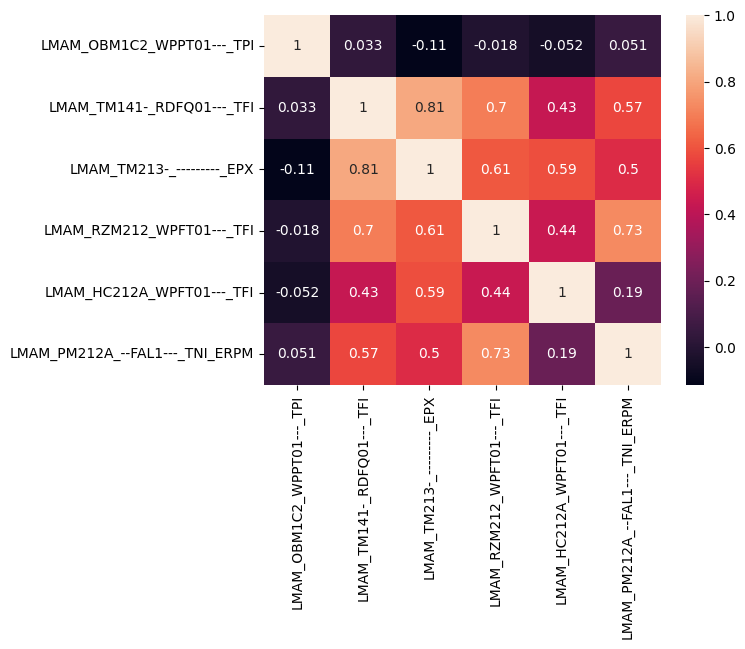

In [22]:
sns.heatmap(clean_df.iloc[:, :].corr(), annot=True)

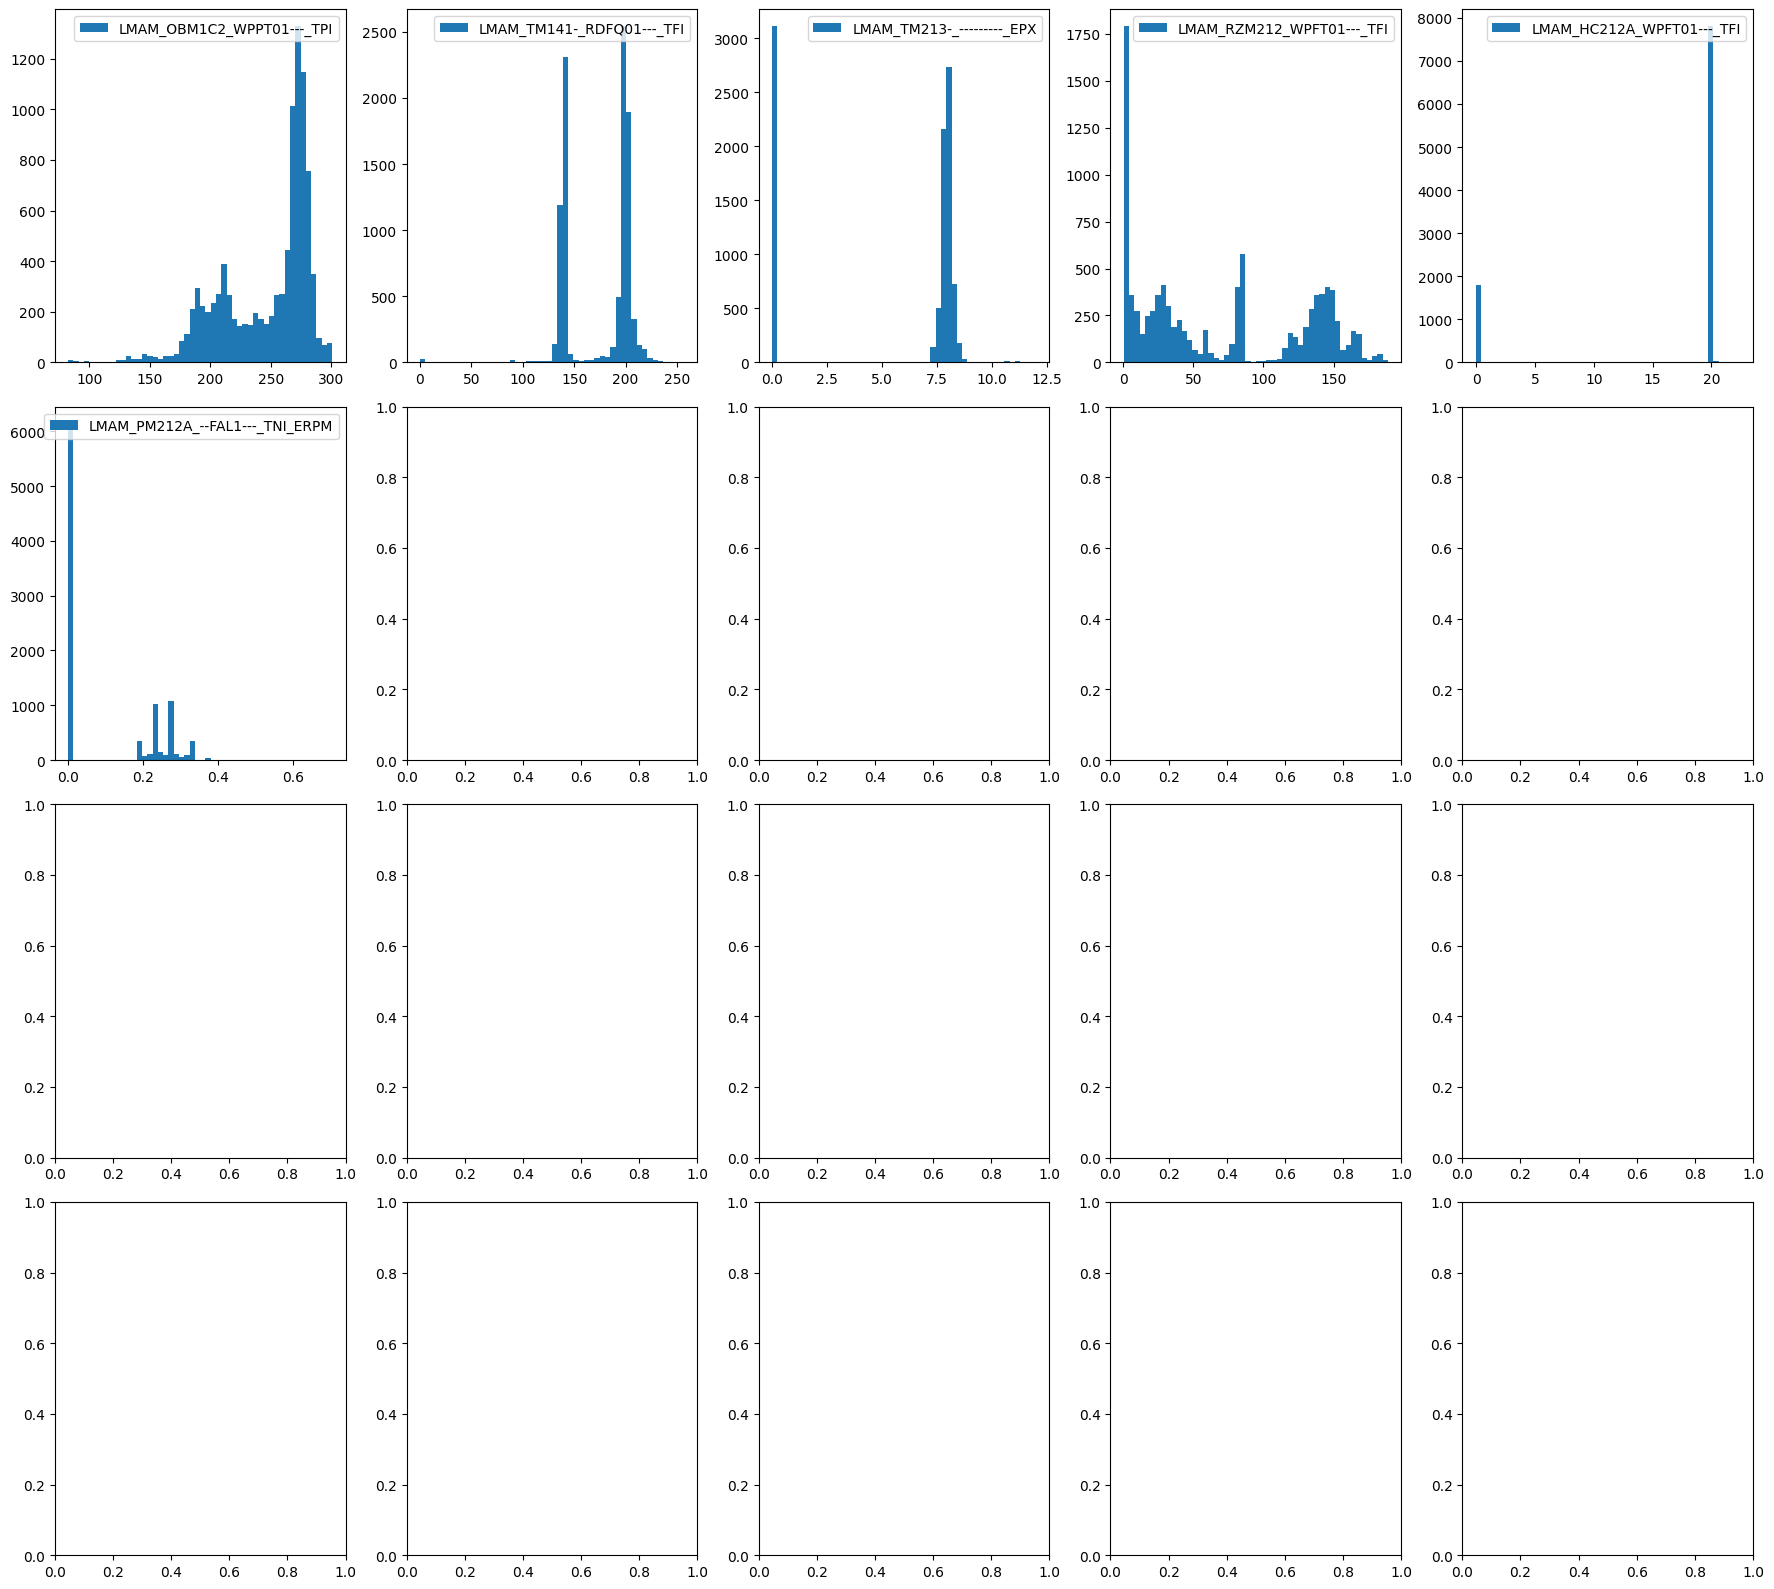

In [23]:
#PLOT HISTOGRAMS

fig, ax =plt.subplots(nrows=4, ncols=5, figsize=(18,16))
ax = ax.flatten()

i = 0
plot_df = clean_df.copy().iloc[:9690]
for c, col in enumerate(plot_df.columns):
    ax[i].hist(plot_df[col], label=col,bins=50)
    ax[i].legend()
    i+=1

plt.tight_layout()
plt.show()

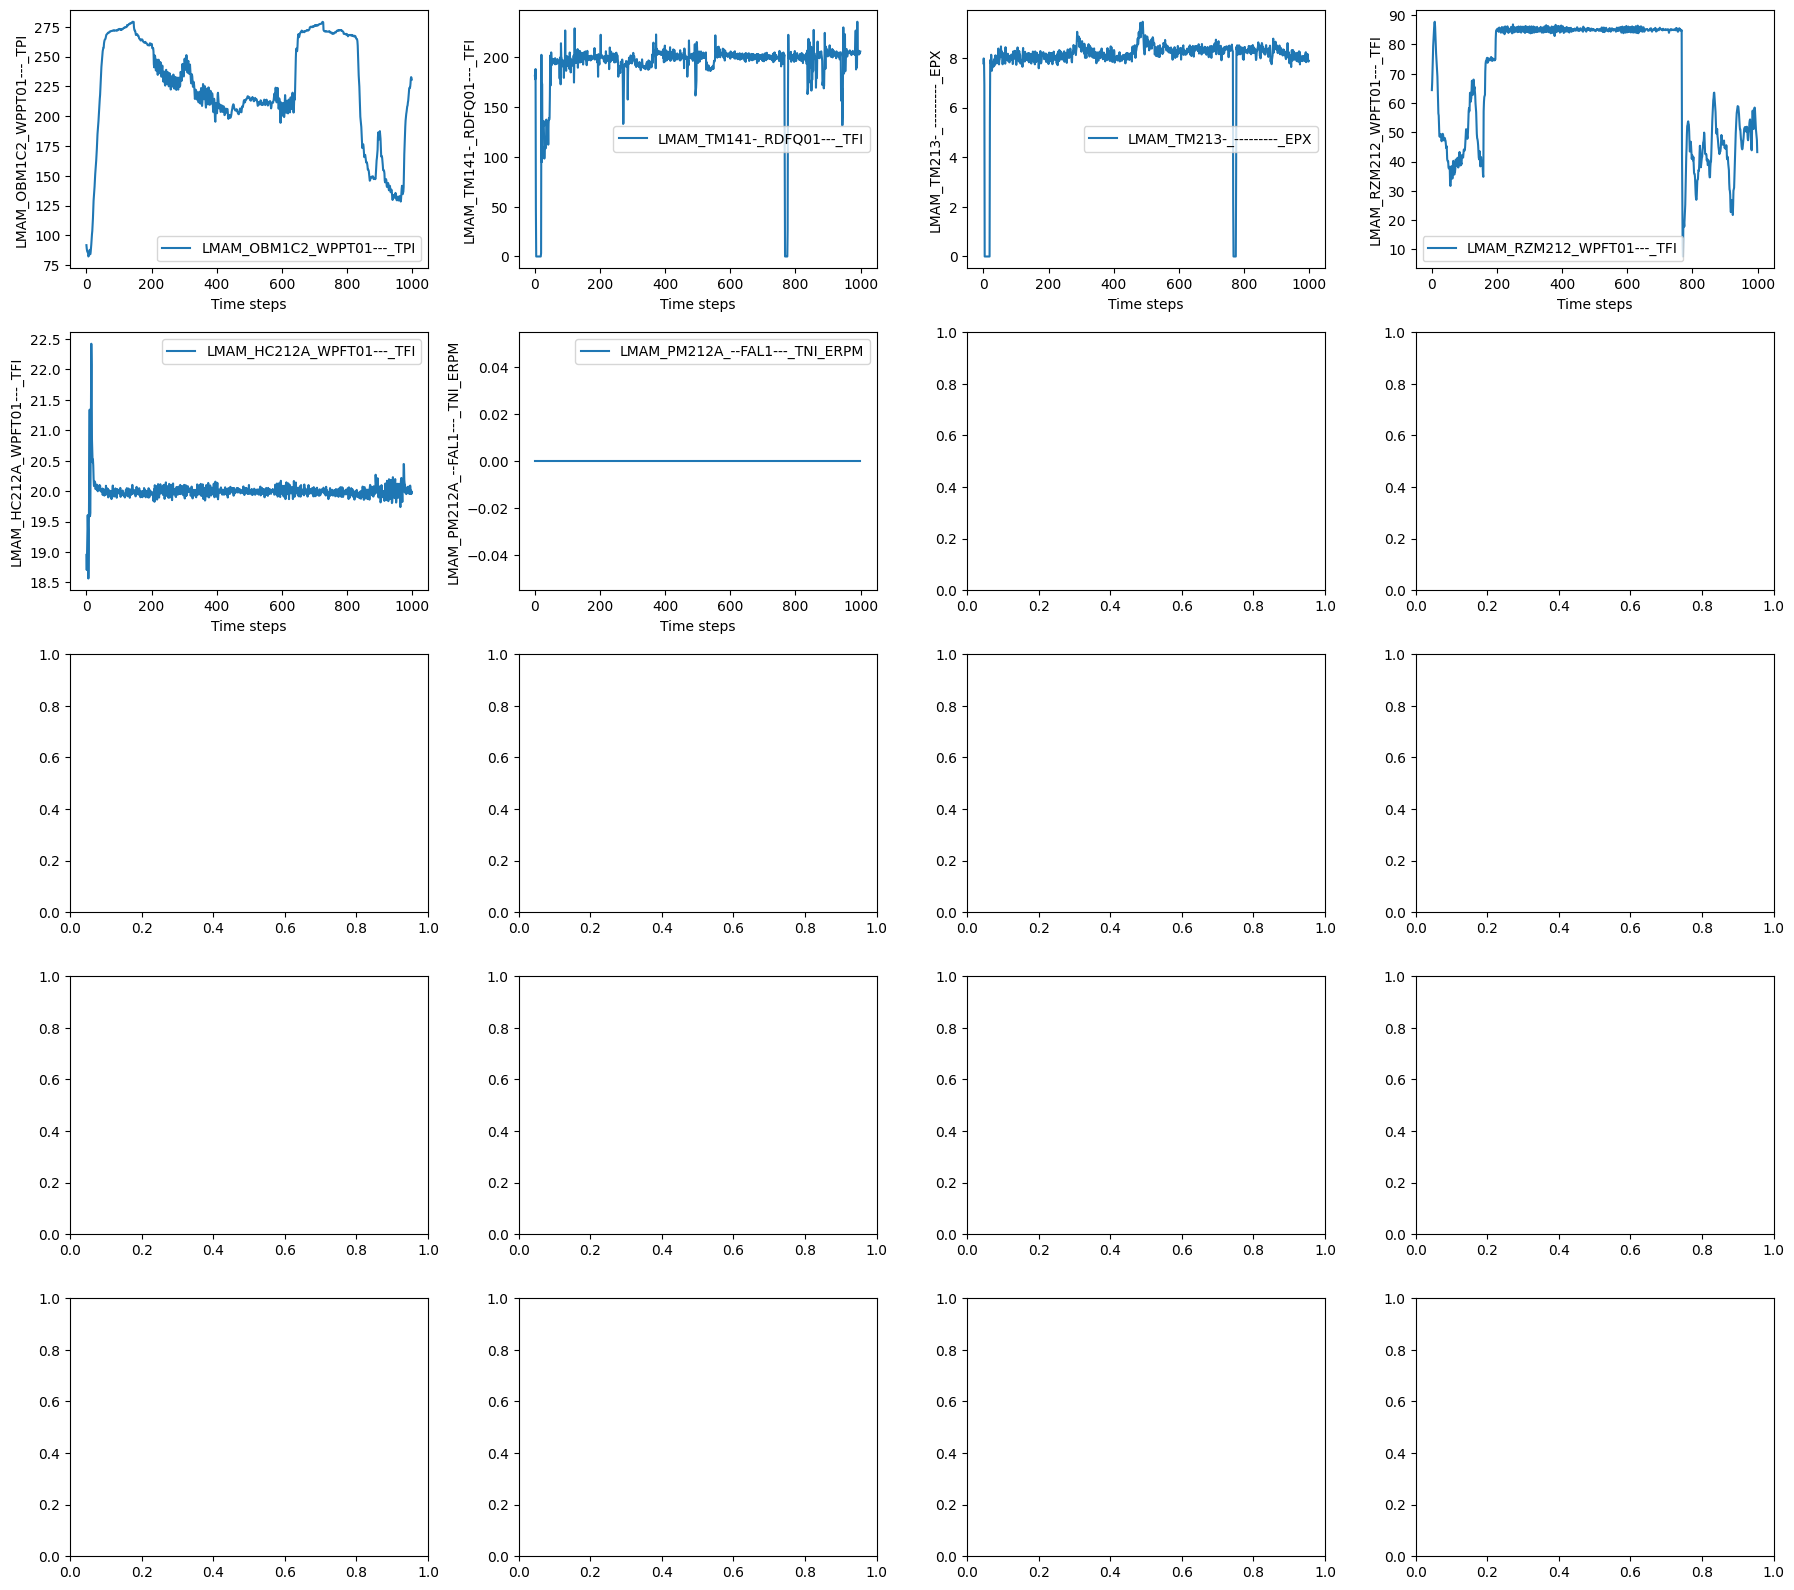

In [24]:
#PLOT PLOT
fig, ax =plt.subplots(nrows=5, ncols=4, figsize=(18,16))
ax = ax.flatten()

i = 0
plot_df = clean_df.copy().iloc[4000:5000]
for c, col in enumerate(plot_df.columns):
    ax[i].plot(range(len(plot_df)), plot_df[col], label=col)
    ax[i].set_xlabel('Time steps')
    ax[i].set_ylabel(col)
    ax[i].legend()
    i+=1

plt.tight_layout()
plt.show()

In [11]:
clean_df = clean_df.drop(columns=['LMAM_PM201A_---------_EPX',
       'LMAM_PM201B_--FAL1---_EI3', 'LMAM_PM201B_--FAL1---_TNI_ERPM',])

with open('feature_lists/15cleaned_features.json', 'w') as f:
    json.dump(clean_df.columns.to_list(), f, indent=2)

LMAM_OBM1C2_WPPT01---_TPI    36.957173
LMAM_MP211-_---------_EPX    10.012000
LMAM_MP211-_WLEQ01---_TDI    35.620404
LMAM_MP211-_WPXRFI2--_PV      2.381026
LMAM_TM141-_RDFQ01---_TFI    32.645841
LMAM_TM211-_---------_EPX     0.199374
LMAM_TM212-_---------_EPX     0.461020
LMAM_K211--_WPXRFI1--_PV     10.352232
LMAM_TM213-_---------_EPX     3.800613
LMAM_MF201-_NDXSLI8--_PV      1.201780
LMAM_RZM201_WPXRFI1--_PV      0.031325
LMAM_RZM201_WPFT01---_TFI     0.036597
LMAM_RZM211_WPXRFI1--_PV      4.223115
LMAM_HC201B_NDDT01---_TDI    30.985893
LMAM_HC201B_WPFT01---_TFI     0.192687
dtype: float64
LMAM_OBM1C2_WPPT01---_TPI     246.950744
LMAM_MP211-_---------_EPX     264.416965
LMAM_MP211-_WLEQ01---_TDI    1815.194557
LMAM_MP211-_WPXRFI2--_PV       65.983083
LMAM_TM141-_RDFQ01---_TFI     173.184307
LMAM_TM211-_---------_EPX       5.883304
LMAM_TM212-_---------_EPX       6.370040
LMAM_K211--_WPXRFI1--_PV      249.040272
LMAM_TM213-_---------_EPX       5.219485
LMAM_MF201-_NDXSLI8--_PV       

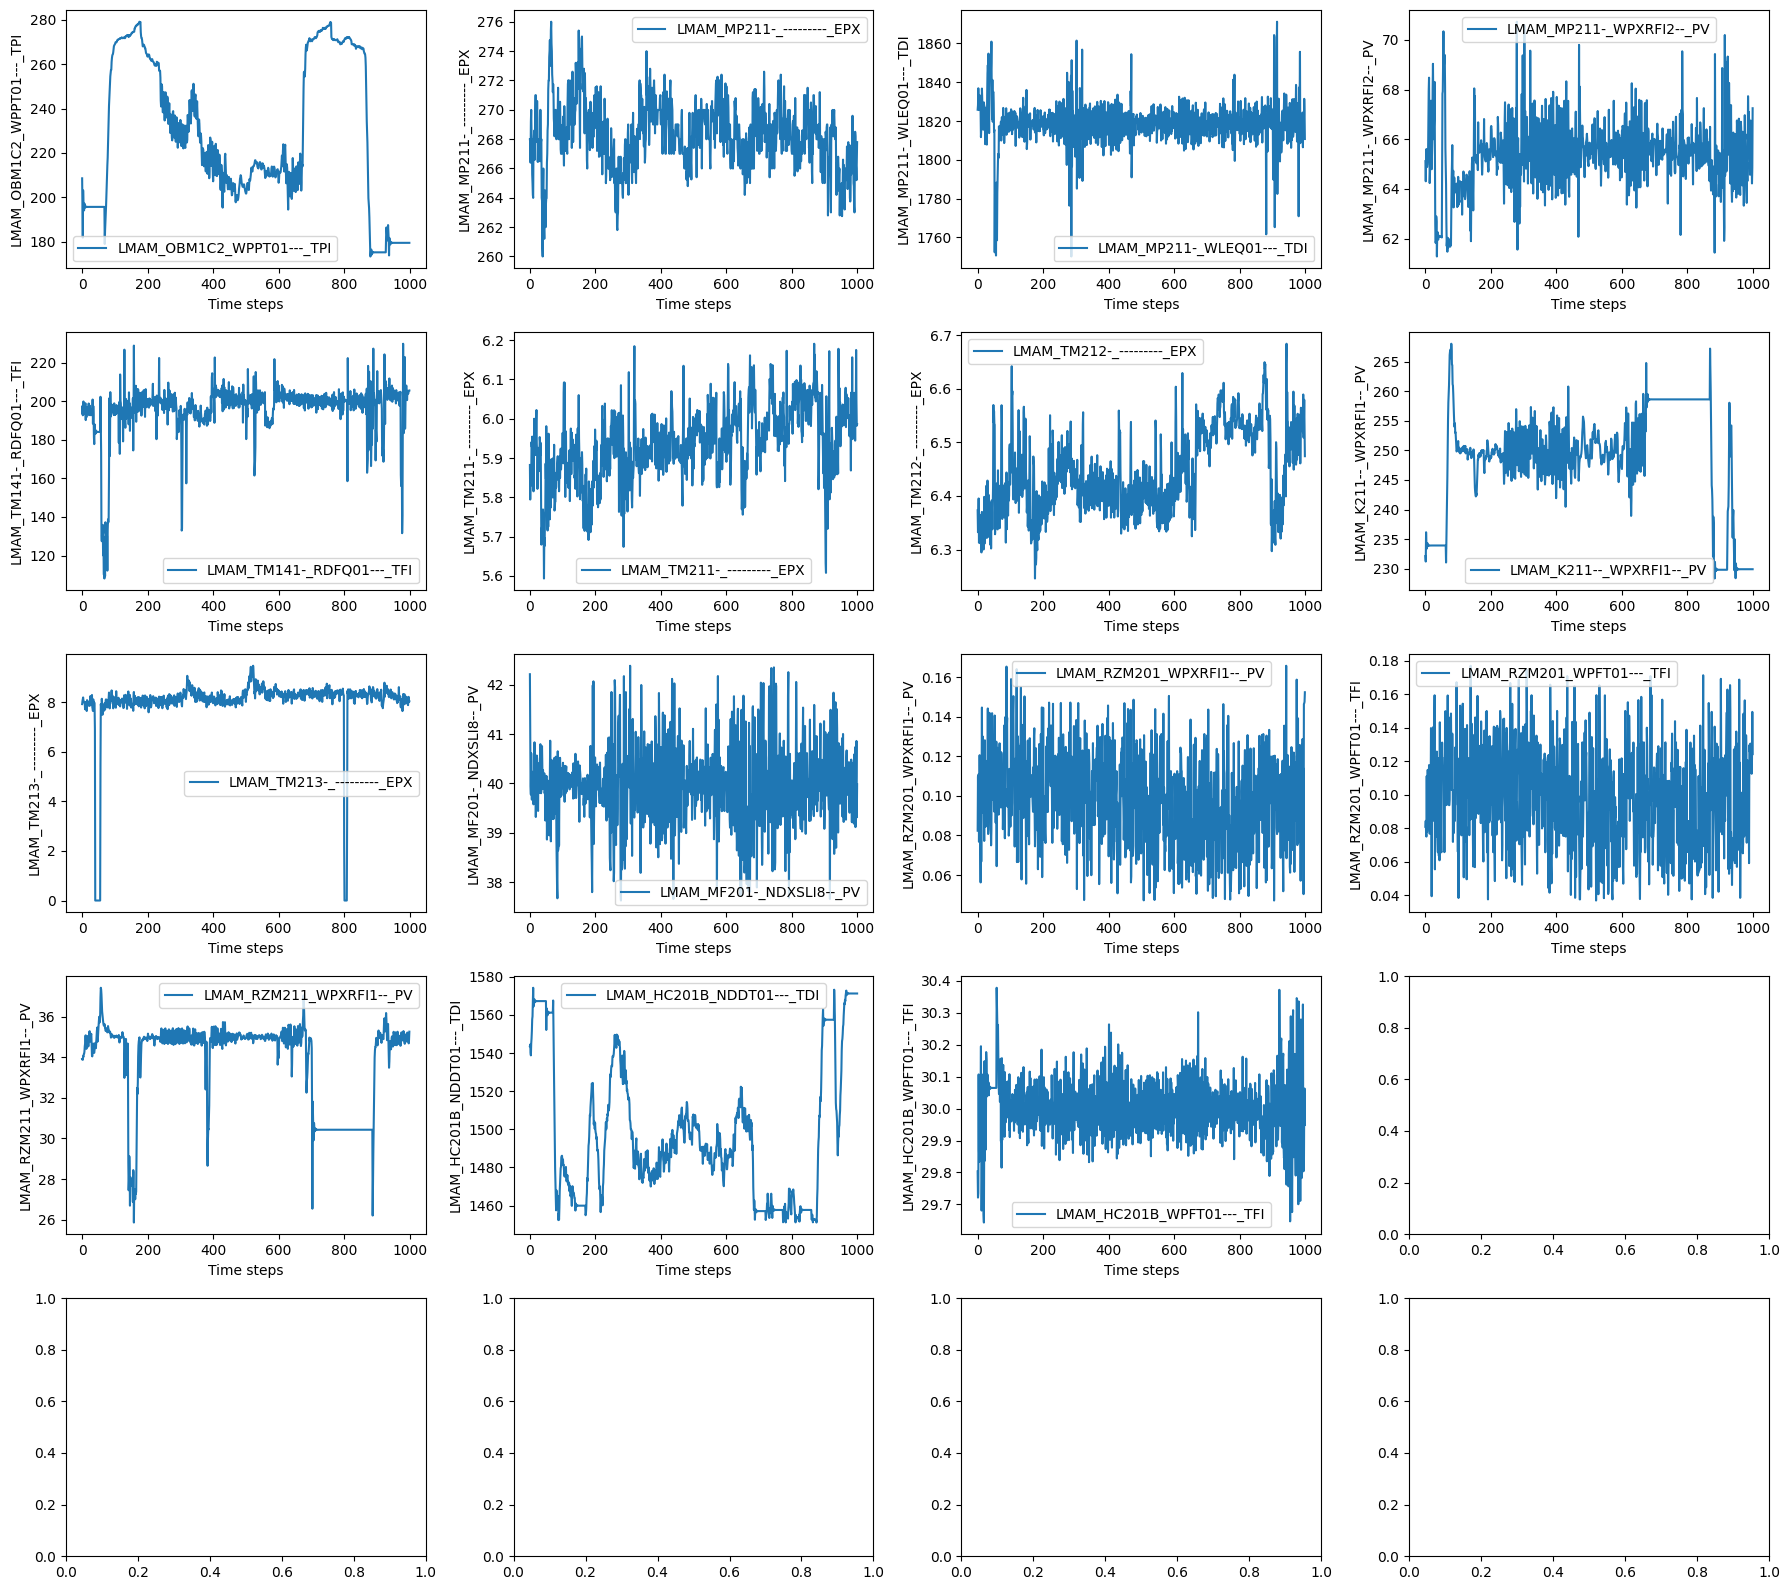

In [12]:


#PLOT PLOT
from processing.smoothing import wma_smoothing

smooth_df = wma_smoothing(clean_df, outlier_n_stdev=2)

fig, ax =plt.subplots(nrows=5, ncols=4, figsize=(18,16))
ax = ax.flatten()

i = 0
plot_df = smooth_df.copy().iloc[4000:5000]
for c, col in enumerate(plot_df.columns):
    ax[i].plot(range(len(plot_df)), plot_df[col], label=col)
    ax[i].set_xlabel('Time steps')
    ax[i].set_ylabel(col)
    ax[i].legend()
    i+=1

plt.tight_layout()
plt.show()

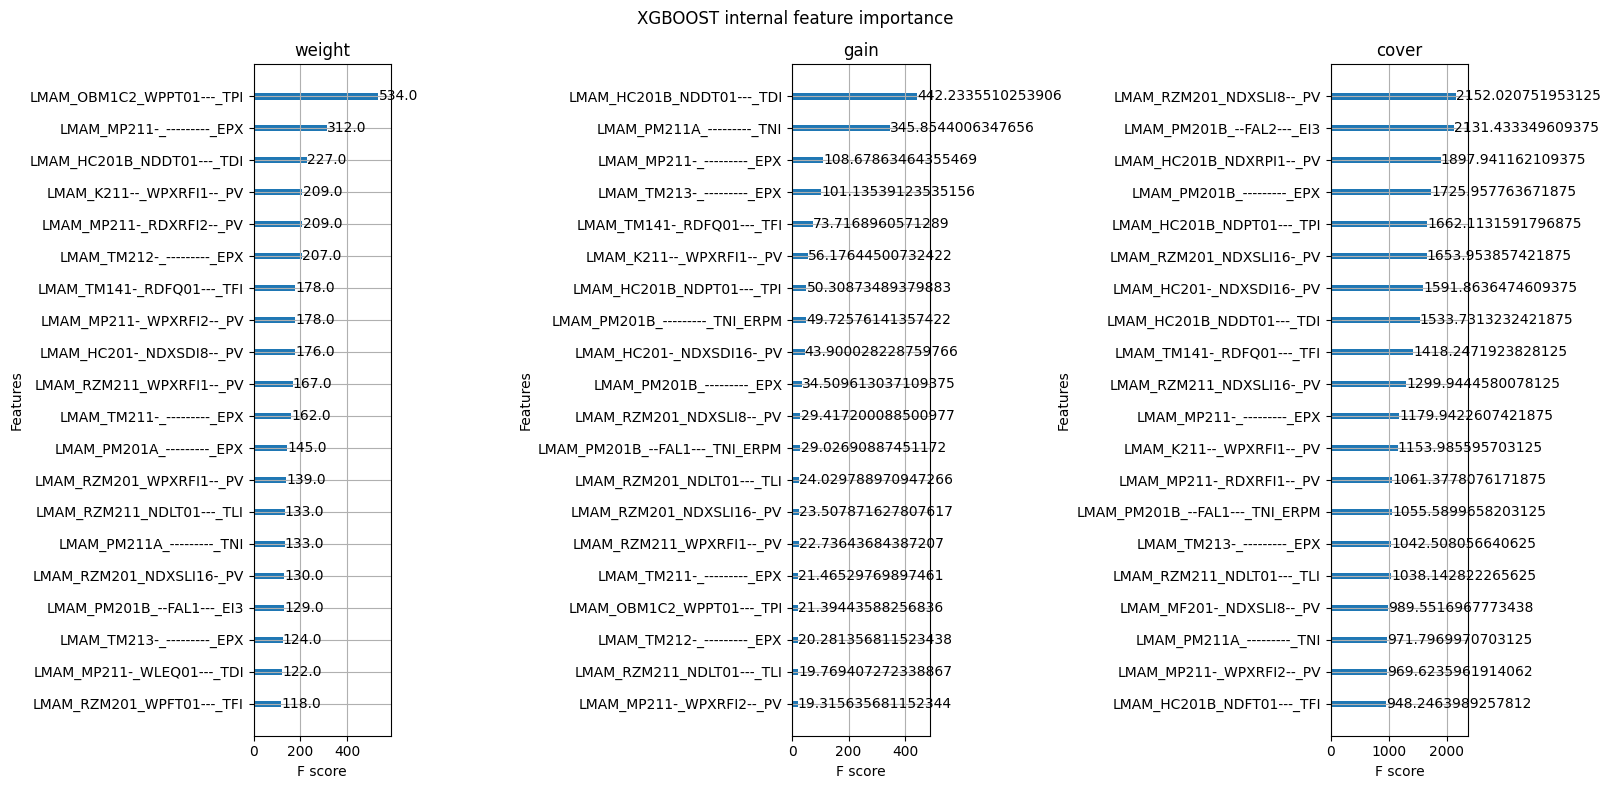

In [13]:
# plot feature importance
fig, ax = plt.subplots(ncols=3, figsize=(16,8))
plot_importance(model, max_num_features=20, ax=ax[0], title='weight', importance_type='weight')
plot_importance(model, max_num_features=20, ax=ax[1], title='gain', importance_type='gain')
plot_importance(model, max_num_features=20, ax=ax[2], title='cover', importance_type='cover')
plt.suptitle('XGBOOST internal feature importance')
plt.tight_layout()

In [14]:
from shap import TreeExplainer, summary_plot, force_plot

explainer = TreeExplainer(
    model=model
)

In [15]:
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


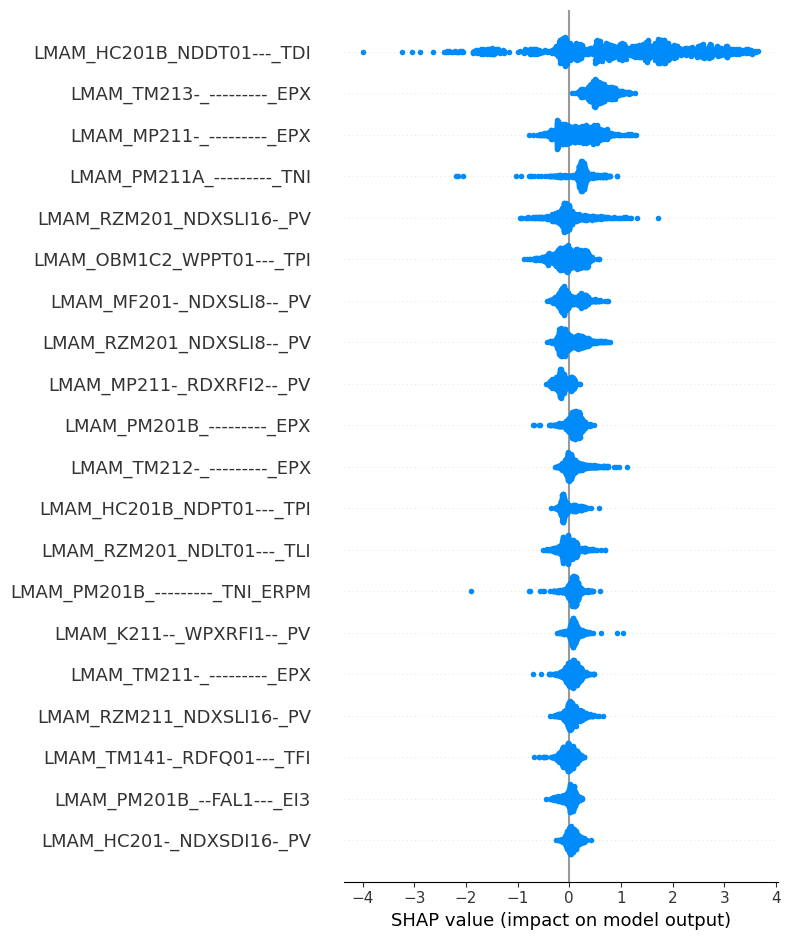

In [16]:
summary_plot(shap_values, features=X_test.columns.to_list(), max_display=20)